In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile
---

## VEST's Documentation File


Election results from Tennessee Secretary of State (https://sos.tn.gov/products/elections/election-results)
Precinct shapefile from Tennessee Comptroller's Office of Local Government

Hamilton County updated with new shapefile from the county's GIS department.

In some counties, early voting write-in votes are only reported countywide. These votes are apportioned to precincts in the same shares that the Election Day vote was split among precincts within a county.

G16PRERTru - Donald J. Trump (Republican Party) \
G16PREDCli - Hillary Clinton (Democratic Party) \
G16PREIDeL - Roque De La Fuente (Independent) \
G16PRELJoh - Gary Johnson (Libertarian Party) \
G16PRESKen - Alyson Kennedy (Independent) \ 
G16PREISmi - Mike Smith (Independent) \
G16PREGSte - Jill Stein (Green Party) \
G16PREOth - Write-in Votes

### Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/tn_2016/tn_2016.shp")

In [3]:
vest_shp.shape

(1983, 11)

In [4]:
vest_shp.head(1)

,NAME,VTD,G16PRERTru,G16PREDCli,G16PREIDeL,G16PRELJoh,G16PRESKen,G16PREISmi,G16PREGSte,G16PREOth,geometry
0,8,1611,427,84,0,11,0,2,1,0,"POLYGON ((1062297.672 552842.892, 1062351.220 ..."


<AxesSubplot:>

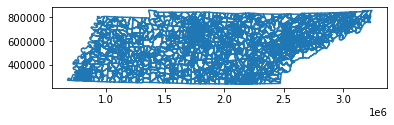

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['NAME', 'VTD', 'G16PRERTru', 'G16PREDCli', 'G16PREIDeL', 'G16PRELJoh',
       'G16PRESKen', 'G16PREISmi', 'G16PREGSte', 'G16PREOth', 'geometry'],
      dtype='object')

# Load the SOS File

The SOS directed to this link for election results for the 2016 general: https://sos.tn.gov/products/elections/election-results

In [7]:
# Import file
president_election_16 = pd.read_excel("./raw-from-source/2016_TN_Election_Results.xlsx")

In [8]:
president_election_16.head()

,COUNTY,PRCTSEQ,PRECINCT,BALSEQID,JURISID,CANDGROUP,OFFICENAME,ELECTDATE,ELECTTYPE,COL1HDG,...,PARTY8,PVTALLY8,COL9HDG,RNAME9,PARTY9,PVTALLY9,COL10HDG,RNAME10,PARTY10,PVTALLY10
0,Anderson,1,Andersonville,3,0,1,United States President,2016-11-08,State General,1,...,NaN,1.0,9.0,Write-In - Cherunda Fox,NaN,0.0,10.0,Write-In - Tom Hoefling,NaN,0.0
1,Anderson,1,Andersonville,3,0,2,United States President,2016-11-08,State General,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anderson,1,Andersonville,11,3,0,United States House of Representatives District 3,2016-11-08,State General,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Anderson,1,Andersonville,17,36,0,Tennessee House of Representatives District 36,2016-11-08,State General,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Anderson,2,Briceville,3,0,1,United States President,2016-11-08,State General,1,...,NaN,0.0,9.0,Write-In - Cherunda Fox,NaN,0.0,10.0,Write-In - Tom Hoefling,NaN,0.0


## Clean Up the Election Results
Tennessee had 8 different presidential write-in candidates and votes were counted seperately. All write-in votes have been been combined here.

In [9]:
# Filter down rows containing presidential election results
president_election_16 = president_election_16[president_election_16['OFFICENAME'] == 'United States President']

# Filter down columns
cols = ['COUNTY','PRECINCT','COL1HDG','PVTALLY1','PVTALLY2','PVTALLY3','PVTALLY4','PVTALLY5','PVTALLY6','PVTALLY7','PVTALLY8','PVTALLY9','PVTALLY10']
president_election_16 = president_election_16.reindex(columns = cols)

# Create dataframe consisting of first row of presidential election data
president_election_16_1 = president_election_16[president_election_16['COL1HDG'] != 11]
president_election_16_1.reset_index(drop=True, inplace = True)

# Create dataframe consisting of second row of presidential election data
president_election_16_2 = president_election_16[president_election_16['COL1HDG'] == 11]
president_election_16_2 = president_election_16_2.drop(['COUNTY','PRECINCT','COL1HDG','PVTALLY6','PVTALLY7','PVTALLY8','PVTALLY9','PVTALLY10'], axis = 1)

# Rename the columns to avoid duplicate column names
president_election_16_2.columns = ['PVTALLY11','PVTALLY12','PVTALLY13','PVTALLY14','PVTALLY15']
president_election_16_2.reset_index(drop=True, inplace = True)

# Concatenate the second dataframe to the first dataframe
president_election_16 = pd.concat([president_election_16_1,president_election_16_2], axis = 1, ignore_index = False)

# Add all the write-in votes
president_election_16['PVTALLY8'] = president_election_16.PVTALLY8 + president_election_16.PVTALLY9 + president_election_16.PVTALLY10 + president_election_16.PVTALLY11 + president_election_16.PVTALLY12 + president_election_16.PVTALLY13 + president_election_16.PVTALLY14 + president_election_16.PVTALLY15

# Drop all the write-in columns except for the column with sum of all the write-in votes
president_election_16 = president_election_16.drop(['COL1HDG','PVTALLY9','PVTALLY10','PVTALLY11','PVTALLY12','PVTALLY13','PVTALLY14','PVTALLY15'], axis = 1)

# Deal with the index
president_election_16.reset_index(drop=True, inplace = True)

#Rename the columns to match VEST
president_election_16.columns = ['County','Precinct','G16PRERTru', 'G16PREDCli', 'G16PREIDeL', 'G16PRELJoh',
       'G16PRESKen', 'G16PREISmi', 'G16PREGSte', 'G16PREOth']

#Fill n/a values with 0
president_election_16 = president_election_16.fillna(0)

# Validating Election Results

## Statewide Candidate Totals

In [10]:
data_columns = ['G16PRERTru', 'G16PREDCli', 'G16PREIDeL', 'G16PRELJoh',
       'G16PRESKen', 'G16PREISmi', 'G16PREGSte', 'G16PREOth']

print("Printing differences below")
for race in data_columns:
    if (sum(vest_shp[race])- president_election_16[race].sum() != 0):
        print(race+" has a difference of "+str(sum(vest_shp[race])-president_election_16[race].sum())+" votes")
        print("\tVEST: "+str(sum(vest_shp[race]))+" votes")
        print("\tSOURCES: "+str(president_election_16[race].sum())+" votes")
    else:
        print(race + " is equal", "\tVEST: " + str(sum(vest_shp[race])), "\tRDH: " + str(president_election_16[race].sum()))
print("")
print("All other races are equal")

Printing differences below
G16PRERTru is equal 	VEST: 1522925 	RDH: 1522925
G16PREDCli is equal 	VEST: 870695 	RDH: 870695.0
G16PREIDeL is equal 	VEST: 4075 	RDH: 4075.0
G16PRELJoh is equal 	VEST: 70397 	RDH: 70397.0
G16PRESKen is equal 	VEST: 2877 	RDH: 2877.0
G16PREISmi is equal 	VEST: 7276 	RDH: 7276.0
G16PREGSte is equal 	VEST: 15993 	RDH: 15993.0
G16PREOth has a difference of -3.0 votes
	VEST: 13786 votes
	SOURCES: 13789.0 votes

All other races are equal


## County Totals

### Add in County FIPs Data

In [11]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Tennessee"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
TN_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

#Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"DeKalb":"Dekalb"}
president_election_16["County"] = president_election_16["County"].map(county_name_changes_dict).fillna(president_election_16["County"])

#Use the dictionary to go from a county name to a county FIPS
president_election_16["County"] = president_election_16["County"].map(TN_fips_dict).fillna(president_election_16["County"])

# #Make sure the county names in the dataframe match the FIPs file
print(president_election_16["County"].unique())

#Check the number of counties - looking for 95
print(len(president_election_16["County"].unique()))

['001' '003' '005' '007' '009' '011' '013' '015' '017' '019' '021' '023'
 '025' '027' '029' '031' '033' '035' '037' '039' '041' '043' '045' '047'
 '049' '051' '053' '055' '057' '059' '061' '063' '065' '067' '069' '071'
 '073' '075' '077' '079' '081' '083' '085' '087' '089' '091' '093' '095'
 '097' '099' '101' '103' '105' '111' '113' '115' '117' '119' '107' '109'
 '121' '123' '125' '127' '129' '131' '133' '135' '137' '139' '141' '143'
 '145' '147' '149' '151' '153' '155' '157' '159' '161' '163' '165' '167'
 '169' '171' '173' '175' '177' '179' '181' '183' '185' '187' '189']
95


### Check the Results

In [12]:
vest_shp['NAME']

0                     8
1                     6
2               Mayland
3                Rinnie
4                 Woody
             ...       
1978          Concord 6
1979         Meadowview
1980          Concord 3
1981         Harrison 6
1982    Middle Valley 1
Name: NAME, Length: 1983, dtype: object

In [13]:
print(len(list(vest_shp["VTD"].str[0:2].unique())))

99


In [14]:
vest_shp.columns

Index(['NAME', 'VTD', 'G16PRERTru', 'G16PREDCli', 'G16PREIDeL', 'G16PRELJoh',
       'G16PRESKen', 'G16PREISmi', 'G16PREGSte', 'G16PREOth', 'geometry'],
      dtype='object')

In [15]:
president_election_16['Precinct']

0       Andersonville
1          Briceville
2            Bull Run
3             Clinton
4        Clinton High
            ...      
2017             24-1
2018             25-1
2019             25-2
2020      Provisional
2021         Absentee
Name: Precinct, Length: 2022, dtype: object

In [16]:
print("Counties with differences printed below:")
diff_counties=[]
for i in data_columns:
    diff = vest_shp.groupby(['NAME']).sum()[i]-president_election_16.groupby(["County"]).sum()[i]
    diff = diff.dropna()
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


In [17]:
## Checking to see if the names match
vest_shp['NAME'].to_csv("./raw-from-source/vest.csv")
president_election_16['Precinct'].to_csv("./raw-from-source/election.csv")

## Precinct Totals

In [18]:
president_election_16

,County,Precinct,G16PRERTru,G16PREDCli,G16PREIDeL,G16PRELJoh,G16PRESKen,G16PREISmi,G16PREGSte,G16PREOth
0,001,Andersonville,1222,227.0,2.0,32.0,1.0,7.0,5.0,4.0
1,001,Briceville,243,42.0,3.0,5.0,0.0,1.0,0.0,0.0
2,001,Bull Run,1397,424.0,3.0,76.0,2.0,13.0,6.0,9.0
3,001,Clinton,1330,556.0,5.0,47.0,2.0,19.0,8.0,4.0
4,001,Clinton High,792,279.0,2.0,33.0,4.0,7.0,7.0,9.0
...,...,...,...,...,...,...,...,...,...,...
2017,189,24-1,1097,431.0,0.0,46.0,2.0,7.0,14.0,4.0
2018,189,25-1,1122,362.0,2.0,68.0,2.0,1.0,13.0,13.0
2019,189,25-2,809,299.0,4.0,32.0,1.0,3.0,9.0,7.0
2020,189,Provisional,102,29.0,0.0,6.0,1.0,0.0,0.0,1.0


In [19]:
vest_shp[vest_shp["VTD"].str[0:2]=="00"]

,NAME,VTD,G16PRERTru,G16PREDCli,G16PREIDeL,G16PRELJoh,G16PRESKen,G16PREISmi,G16PREGSte,G16PREOth,geometry
203,South Clinton,0025,674,177,1,30,2,7,2,3,"POLYGON ((2524238.359 650543.402, 2524285.185 ..."
204,Clinton,0005,1330,556,5,47,2,19,8,4,"POLYGON ((2519904.139 655243.169, 2519967.934 ..."
205,Clinton High,0006,792,279,2,33,4,7,7,9,"POLYGON ((2519164.078 656998.207, 2519192.147 ..."
206,Emory Valley,0009,1034,894,1,88,3,15,19,18,"POLYGON ((2498873.357 638492.820, 2498878.010 ..."
207,Pine Valley,0022,748,606,5,84,2,8,22,4,"POLYGON ((2494377.796 632945.051, 2492916.176 ..."
208,Oak Ridge City Hall,0021,324,521,0,33,2,0,7,4,"POLYGON ((2485778.576 613695.356, 2485787.412 ..."
209,West Hills,0026,740,574,2,70,2,4,13,12,"POLYGON ((2471758.170 615912.603, 2471841.954 ..."
210,Bull Run,0003,1397,424,3,76,2,13,6,9,"POLYGON ((2513388.054 636239.526, 2513503.180 ..."
211,Claxton,0004,1319,387,2,53,0,8,5,8,"POLYGON ((2538534.210 669008.368, 2538632.154 ..."
212,Andersonville,0001,1222,227,2,32,1,7,5,4,"POLYGON ((2552432.465 711304.445, 2552610.040 ..."


In [20]:
vest_shp["VTD"].str[0:2].sort_values().unique()

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98'],
      dtype=object)

In [21]:
president_election_16["County"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '111',
       '113', '115', '117', '119', '107', '109', '121', '123', '125',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '163', '165', '167', '169', '171', '173', '175', '177', '179',
       '181', '183', '185', '187', '189'], dtype=object)

In [22]:
president_election_16.to_csv("./unmod_source_tn.csv")
vest_shp.to_csv("./unmod_vest_tn.csv")

In [23]:
to_allocate_list = ['Early voting',
'Early Voting - Write-Ins',
'Provisional - Write-Ins',
'Provisional',
'Absentee',
'Paper Ballots']

to_allocate = president_election_16[president_election_16["Precinct"].isin(to_allocate_list)]
to_add_to = president_election_16[~president_election_16["Precinct"].isin(to_allocate_list)]

In [24]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [25]:
president_allocated = allocate_absentee(to_add_to,to_allocate,data_columns,'County')

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [26]:
print(president_allocated.head())

  County       Precinct  G16PRERTru  G16PREDCli  G16PREIDeL  G16PRELJoh  \
0    001  Andersonville      1222.0       227.0         2.0        32.0   
1    001     Briceville       243.0        42.0         3.0         5.0   
2    001       Bull Run      1397.0       424.0         3.0        76.0   
3    001        Clinton      1330.0       556.0         5.0        47.0   
4    001   Clinton High       792.0       279.0         2.0        33.0   

   G16PRESKen  G16PREISmi  G16PREGSte  G16PREOth  
0         1.0         7.0         5.0        4.0  
1         0.0         1.0         0.0        0.0  
2         2.0        13.0         6.0        9.0  
3         2.0        19.0         8.0        4.0  
4         4.0         7.0         7.0        9.0  


In [27]:
president_allocated["Precinct"].value_counts(dropna=False)

5-1                  8
4-1                  8
3-1                  8
2-1                  8
1-1                  8
                    ..
220 Collegedale 6    1
217 Collegedale 5    1
204 Collegedale 4    1
167 Collegedale 3    1
9-5                  1
Name: Precinct, Length: 1791, dtype: int64

In [28]:
vest_shp["VTD"].value_counts(dropna=False)
vest_shp["NAME"].value_counts(dropna=False)

6-1                5
1-1                5
3-1                5
5-1                5
4-1                5
                  ..
76                 1
87                 1
82                 1
86                 1
Middle Valley 1    1
Name: NAME, Length: 1860, dtype: int64

In [29]:
print(vest_shp.head())

      NAME   VTD  G16PRERTru  G16PREDCli  G16PREIDeL  G16PRELJoh  G16PRESKen  \
0        8  1611         427          84           0          11           0   
1        6  1612         403          89           0           9           0   
2  Mayland  1714         820         160           1          16           1   
3   Rinnie  1720         385          41           0           4           0   
4    Woody  1724         897         135           0          24           0   

   G16PREISmi  G16PREGSte  G16PREOth  \
0           2           1          0   
1           1           1          4   
2           2           6          0   
3           0           2          2   
4           1           3          4   

                                            geometry  
0  POLYGON ((1062297.672 552842.892, 1062351.220 ...  
1  POLYGON ((1073149.732 567498.520, 1073241.043 ...  
2  POLYGON ((2194261.307 646054.262, 2194269.288 ...  
3  POLYGON ((2255492.241 669749.802, 2255484.749 ...  
4  

In [30]:
president_allocated["unique_ID"] = president_allocated["County"]+"-"+president_allocated["Precinct"]

C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [31]:
vest_shp["unique_ID"] = vest_shp["VTD"]+"-"+vest_shp["NAME"]

In [32]:
print(data_columns)

['G16PRERTru', 'G16PREDCli', 'G16PREIDeL', 'G16PRELJoh', 'G16PRESKen', 'G16PREISmi', 'G16PREGSte', 'G16PREOth']


In [33]:
#From looking at the precincts, we noticed that VEST merges the 2 West Chester precincts with one another, as well as the 2 East Chester precincts

In [34]:
for race in data_columns:
    president_allocated.loc[president_allocated["unique_ID"]=="023-4-1 West Chester - City",race]+=int(president_allocated.loc[president_allocated["unique_ID"]=="023-4-1 West Chester",race])
    president_allocated.loc[president_allocated["unique_ID"]=="023-5-1 East Chester",race]+=int(president_allocated.loc[president_allocated["unique_ID"]=="023-5-1 East Chester - City",race])
    
president_allocated = president_allocated[president_allocated["unique_ID"]!="023-4-1 West Chester"]
president_allocated = president_allocated[president_allocated["unique_ID"]!="023-5-1 East Chester - City"]

#Update
president_allocated.loc[president_allocated["unique_ID"]=="023-4-1 West Chester - City","unique_ID"]="1102-4-1 West Chester School"
president_allocated.loc[president_allocated["unique_ID"]=="023-5-1 East Chester","unique_ID"]="1105-5-1 East Chester School"

president_allocated.reset_index(inplace=True,drop=True)


C:\Users\youhy\anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [35]:
source_changes_dict ={'093-61 Halls': '4886-61', '093-66N Farragut I': '4805-66-N', '093-66S Farragut II': '4842-66-S', '163-4A': '8502-4A', '093-73 Powell': '4892-73', '163-6A': '8520-6A', '093-81 Gibbs': '4812-81', '165-7-3 Long Hollow': '8628-703 Long Hollow Baptist Church', '011-2-1 E.L. Ross': '0504-201 E.L. Ross School', '125-3 East Montgomery': '6453-3', '155-4-1 Pigeon Forge': '7957-Pigeon Forge 2', '093-65W Concord': '4897-65-W', '157-Lakeland 01': '8096-Lakeland 1', '093-63 Karns': '4848-63', '165-6-1 Vol State': '8601-601 Vol State College', '163-11A': '8506-11A', '155-6-1 Seymour': '7968-Seymour Intm.Sch. 2', '093-59 Brickey': '4887-59', '093-65E Shoreline': '4841-65-E', '009-Wm Blount Academy': '0419-William Blount Academy', '187-7-1': '9722-7-1 Brenthaven Church', '167-4-11 Atoka': '8709-11 Atoka', '163-8A': '8510-8A', '165-9-2 Indian Lake': '8620-902 Indian Lake Elementary', '157-Arlington 01': '8051-ARL-01', '125-15 Sango': '6468-15', '011-1-2 Prospect': '0516-102 Prospect School', '119-Spring Hill 11-2': '5951-Spring Hill', '047-Oakland': '2451-6 Oakland', '093-70E Amherst': '4828-70-E', '009-Montvale': '0427-Montvale', '165-7-1 Whitten': '8622-701 Whitten Elementary', '157-Collierville 01': '8068-Collierville 1', '157-Bartlett 08': '8058-Bartlett 08', '149-20-1': '7693-20-1 Blackman United Methodist Church', '093-71 Rocky Hill': '4835-71', '189-11-1': '9815-11-1', '155-9-1 Seymour Primary': '7965-Seymour Primary Sch. 2', '163-9A': '8511-9A', '125-19 Oakland': '6471-19', '165-4-1 Howard': '8611-401 Howard Elementary School', '011-4-2 Michigan Ave': '0508-402 Michigan Ave School', '105-Eaton': '5463-Eatons', '149-14-2': '7680-14-2 Siegel Elementary School', '187-9-3': '9730-9-3 Westhaven Clubhouse', '165-12-3 White House': '8626-1203 White House Middle School', '165-12-1 Oakmont': '8612-1201 Oakmont Elementary', '149-20-2': '7694-20-2 Blackman High School', '163-10A': '8522-10A', '163-5A': '8513-5A', '187-12-2': '9739-12-2 The Church of the City-Franklin', '011-7-1 Stuart': '0502-701 Stuart School', '157-Germantown 04': '8088-Germantown 04', '187-3-1': '9709-3-1 Heritage Elementary School', '187-6-1': '9719-6-1 Brentwood Library', '163-6B': '8521-6B', '011-2-2 Walker Valley': '0505-202 Walker Valley High', '125-7 Woodlawn': '6455-7', '165-6-3 Jack Anderson': '8602-603 Jack Anderson Elementary', '073-2 Church Hill Inside': '3825-2 Church Hill Inside', '179-15 Courthouse': '9310-15 Courthouse', '011-3-2 Senior Center': '0506-302 Senior Center', '157-Germantown 05': '8089-Germantown 05', '093-70W Ball Camp': '4847-70-W', '093-67 North Cedar Bluff': '4852-67', '187-8-2': '9726-8-2 First Presbyterian Church', '089-3 White Pine': '4603-3rd White Pine School', '149-7-2': '7664-7-2 Barfield Elementary School', '167-5-12 Munford': '8707-12 Munford', '187-2-2': '9706-2-2 Thompson Station Baptist Church', '157-Stewartville': '8270-Stewartville', '165-10-2 Merrol Hyde': '8633-1002 Merrol Hyde Magnet School', '035-9 Fairfield South': '1709-Fairfield Glade South', '065-075 Pleasant Grove 1': '3353-Pleasant Grove 1', '053-1-1 Medina': '2751-01 Medina', '149-6-1': '7661-6-1 Whitworth-Buchannan Middle School', '157-Collierville 04': '8071-Collierville 4', '149-14-1': '7679-14-1 Siegel Middle School', '149-9-1': '7669-9-1 Stewarts Creek Elementary School', '021-3-1 Pleasant View': '1003-3-1 Pleasant View City Hall', '165-3-1 Civic Center': '8635-301 Gallatin Civic Center', '157-Bartlett 09': '8053-Bartlett 09', '189-5-1': '9806-5-1', '179-06 Sulphur Springs': '9339-6 Sulphur Springs', '167-3-6 Tipton West': '8704-06 Tipton West', '093-64 Solway': '4846-64', '189-3-1': '9803-3-1', '157-Germantown 02': '8086-Germantown 02', '157-Germantown 11': '8094-Germantown 11', '163-7A': '8519-7A', '163-2A': '8501-2A', '165-9-1 Hendersonville': '8603-901 Hendersonville High School', '009-Eagleton MS Cafeteria': '0431-Eagleton Cafeteria', '093-72 Dante': '4888-72', '155-8-1 Kodak': '7969-Kodak 1', '065-083 Soddy Daisy 1': '3328-Soddy Daisy 1', '165-11-2 Goodlettsville': '8623-1102 Church of the Nazarene', '105-Highland Park': '5458-Highland Park', '149-8-1': '7665-8-1 Rockvale Middle School', '157-Collierville 03': '8070-Collierville 3', '165-3-3 Creekside': '8607-303 Creekside Fellowship', '093-69E Bluegrass': '4807-69-E', '187-7-3': '9724-7-3 New Hope Community Church', '037-35-3': '1960-35-3', '037-04-1': '1817-4-1', '119-St. Catherine 4-1': '5956-St. Catherine', '187-4-1': '9712-4-1 Prairie Life Fitness Center', '149-9-2': '7670-9-2 Browns Chapel Elementary School', '093-45 Bearden Middle': '4854-45', '011-4-1 Oak Grove': '0512-401 Oak Grove School', '187-4-2': '9713-4-2 Millview Church of Christ', '157-Millington 01': '8260-Millington 1', '065-205 Ooltewah 4': '3363-Ooltewah 4', '021-2-2 East Cheatham': '1001-2-1 East Cheatham Elementary', '059-4 Camp Creek': '3052-Camp Creek', '157-Collierville 09': '8271-Collierville 9', '113-9-2 Pope': '5681-9-2 Pope Elementary School', '035-9 Fairfield North': '1708-Fairfield Glade North', '149-6-2': '7662-6-2 Christiana Middle School', '093-90 South Doyle': '4824-90', '189-18-1': '9824-18-1', '093-84 Ritta': '4808-84', '035-1 Cornerstone': '1705-Cornerstone Baptist Church', '149-2-2': '7653-2-2 Wilson Elementary School', '065-179 Snowhill 2': '3359-Snowhill 2', '021-6-1 Harpeth': '1006-6-1 Harpeth High School', '167-9-22 Brighton': '8702-22 Brighton', '187-11-3': '9737-11-3 Winstead Elementary School', '157-Memphis 57': '8157-Memphis 57', '157-Bartlett 05': '8056-Bartlett 05', '113-9-1 VFW': '5680-9-1 VFW', '187-4-3': '9714-4-3 Franklin Christian Church', '107-Niota': '6053-08 Niota School', '047-Hickory Withe': '2452-7 Hickory White', '147-02-1 Woodall': '7552-2-1 Robert F. Woodall Elementary School', '073-1 Mount Carmel': '3809-1 Mount Carmel', '065-051 Birchwood': '3322-Birchwood', '147-04-1 Watauga': '7554-4-1 Watauga Elementary School', '149-3-1': '7654-3-1 Leanna Church of Christ', '167-6-14 SW Tipton': '8706-14 Southwest Tipton', '157-Bartlett 04': '8055-Bartlett 04', '189-14-1': '9819-14-1', '187-5-2': '9716-5-2 Nolensville Methodist Church', '093-37 Inskip Elementary': '4879-37', '037-12-2': '1855-12-2', '149-2-1': '7698-2-1 Lascassas Elementary School', '065-048 Lookout Valley 1': '3326-Lookout Valley 1', '155-5-1 Sevierville': '7963-Middle School 2', '011-1-3 Hopewell': '0517-103 Hopewell School', '179-03 Gray East': '9335-3 Gray East', '149-15-1': '7681-15-1 John Pittard Elementary', '065-090 Harrison 2': '3341-Harrison 2', '119-Pleasant Heights 9-2': '5964-Pleasant Heights', '187-8-3': '9727-8-3 Episcopal Church', '187-10-1': '9732-10-1 Franklin Recreation Complex', '187-5-4': '9718-5-4 Nolensville Baptist Church', '163-4B': '8515-4B', '123-01': '6351-Sweetwater High School', '065-088 Hixson 2': '3355-Hixson 2', '105-Tellico V. South': '5464-Tellico Village South', '019-Happy Valley': '0901-Happy Valley', '119-Bear Creek 8-1': '5966-Bear Creek', '189-23-1': '9830-23-1', '093-69S Northshore': '4839-69-S', '147-01-1 East Robertson': '7551-1-1 East Robertson Elementary School', '163-2B': '8517-2B', '167-7-19 Austin Peay': '8703-19 Austin Peay', '165-8-2 Hawkins': '8631-802 Hawkins Middle School', '147-05-1 Greenbrier': '7555-5-1 Greenbrier High School', '093-47 Bearden High': '4837-47', '011-5-1 Blythe/Bower': '0514-501 Blythe/Bower School', '189-13-1': '9818-13-1', '167-8-21 Wilkinsville': '8701-21 W. Wilkinsville', '145-Kingston Ward 1': '7456-Kingston Ward 1', '065-207 Signal Mountain 1': '3365-Signal Mountain 1', '157-Millington 02': '8261-Millington 2', '155-11-1 Gatlinburg': '7956-Gatlinburg 2', '037-11-2': '1851-11-2', '107-City Park': '6060-01 City Park School', '037-04-4': '1820-4-4', '179-17 Town Acres': '9330-17 Towne Acres', '163-7B': '8518-7B', '089-1 Dandridge ES': '4604-1st Dandridge Elementary School', '093-68 South Cedar Bluff': '4850-68', '149-4-3': '7658-4-3 Oakland Middle School', '165-8-1 Brown': '8619-801 Brown Elementary', '157-Bartlett 03': '8054-Bartlett 03', '093-69N West Valley': '4840-69-N', '125-2A St B MC': '6464-2A', '189-1-1': '9801-1-1', '165-2-1 Portland': '8614-202 Portland High School', '157-Collierville 06': '8073-Collierville 6', '065-185 Dallas 1': '3339-Dallas 1', '065-033 Mountain Creek 1': '3350-Mountain Creek 1', '011-6-2 Blue Springs': '0515-602 Blue Springs School', '119-CP Church 5-1': '5957-CP Church', '141-9B Double Springs': '7265-09B Double Springs', '163-1A': '8504-1A', '165-1-3 Corinth': '8636-103 Corinth Church of Christ', '187-1-1': '9701-1-1 Westwood Elementary School', '065-104 East Brainerd 2': '3311-East Brainerd 2', '113-10-2 North East': '5668-10-2 North East School', '157-Brunswick 02': '8066-Brunswick 2', '167-2-3 SE Covington': '8705-03 S.E. Covington', '163-3A': '8503-3A', '009-Maryville HS': '0420-Maryville High School', '187-5-3': '9717-5-3 Triune Baptist Church', '059-6 Mosheim': '3082-Mosheim', '187-12-3': '9740-12-3 The Gate Community Church', '093-58S Pedigo': '4891-58-S', '089-2 Piedmont': '4601-2nd Piedmont Elementary School', '179-09 B.C. City': '9334-9 Boones Creek City', '037-31-4': '1943-31-4', '189-10-1': '9814-10-1', '065-050 Apison 1': '3347-Apison 1', '123-11': '6361-Tellico Community Center', '187-6-2': '9720-6-2 Brentwood Safety Center', '003-2-3 Fair Haven': '0103-203 Fairhaven Baptist Church', '155-3-2 Harrisburg': '7954-Harrisburg 2', '157-Germantown 03': '8087-Germantown 03', '051-2-1 Clark Memorial': '2652-2-1 Clark Memorial', '093-69W A. L. Lotts': '4896-69-W', '187-5-1': '9715-5-1 Sunset Elementary School', "179-20 Visitor's Center": "9327-20  Visitor's Center", '165-1-1 Westmoreland': '8632-101 Westmoreland Middle', '189-2-1': '9802-2-1', '187-6-3': '9721-6-3 Holy Family Catholic Church', '003-4-3 Bedford': '0105-403 Bedford Community Center', '125-4A MCMS': '6461-4A', '093-62 Hardin Valley': '4844-62', '115-Jasper': '5754-Jasper', '149-19-1': '7691-19-1 Creekmont General Baptist Church', '157-Collierville 02': '8069-Collierville 2', '093-63N Karns North': '4849-63-N', '157-Bartlett 13': '8063-Bartlett 13', '157-Germantown 10': '8093-Germantown 10', '149-10-2': '7672-10-2 Lifepoint Church', '063-13-1': '3264-13-1', '157-Memphis 91-4': '8080-Memphis 91-4', '065-098 Harrison 3': '3381-Harrison 3', '065-091 Westview 2': '3386-Westview 2', '037-34-3': '1955-34-3', '189-8-1': '9810-8-1', '187-3-2': '9710-3-2 Longview Recreation Center', '105-Browder': '5462-Browder', '187-1-2': '9702-1-2 Fairview Recreation Center', '059-2 Chuckey': '3073-Chuckey', '189-4-1': '9804-4-1', '189-17-1': '9823-17-1', '157-Bartlett 11': '8060-Bartlett 11', '187-7-2': "9723-7-2 Baptist Children's Home", '089-5 Jefferson Middle': '4606-5th Jefferson Middle School', '065-060 Ooltewah 1': '3361-Ooltewah 1', '149-19-2': '7692-19-2 New Vision Baptist Church', '141-1A Capshaw': '7266-01A Capshaw', '105-Lenoir City': '5460-Lenoir City', '189-16-1': '9822-16-1', '093-89 Mt. Olive': '4829-89', '065-078 Red Bank 3': '3351-Red Bank 3', '119-Mt. Pleasant 10-1': '5961-Mt. Pleasant', '179-10 Lakeridge': '9333-10 Lakeridge', '163-2C': '8516-2C', '065-017 East Brainerd 1': '3384-East Brainerd 1', '047-Macon': '2456-11 Macon', '149-7-1': '7663-7-1 New Heights Chapel', '155-10-1 Boyds Creek': "7967-Boyd's Creek 2", '125-20A Clarksville': '6469-20A', '149-3-2': '7655-3-2 Old Jefferson Church of Christ', '187-2-1': '9705-2-1 Bethesda Recreation Center', '063-08-1': '3258-8-1', '009-Alcoa': '0408-Alcoa High School', '187-10-3': "9734-10-3 Hunter's Bend Elementary School", '063-12-1': '3263-12-1', '093-74 Shannondale': '4885-74', '037-01-1': '1801-1-1', '125-6A Cumberland': '6460-6A', '003-3-3 Unionville': '0104-303 Uniounville Fire Hall', '011-7-2 Cleveland High': '0507-702 Cleveland High', '163-10B': '8505-10B', '149-21-2': '7696-21-2 BlackFox Elementary School', '065-101 Hixson 3': '3354-Hixson 3', '009-Board of Education': '0403-Blount County Board of Education', '009-Oakview': '0402-Oak View', '187-12-1': '9738-12-1 Franklin Community of Faith Church', '149-10-1': '7671-10-1 Rock Springs Elementary School', '189-22-1': '9829-22-1', '187-2-3': '9707-2-3 Oakview Elementary School', '165-2-2 Wiseman': '8613-203 Wiseman Elementary', '189-6-1': '9807-6-1', '123-07': '6357-Sequoyah High School', '149-13-2': '7678-13-2 Cason Lane Academy', '107-Etowah': '6064-02 Etowah Community Center', '021-1-1 County Library': '1004-1-1 Cheatham Co Library', '147-10-1 South Haven': '7565-10-1 South Haven Christian School', '133-4-2 Rickman': '6857-4 Rickman', '059-7 Glenwood': '3084-Glenwood', '037-22-3': '1905-22-3', '187-2-5': '9743-2-5 Conduit Church', '187-9-2': '9729-9-2 Benton Hall School', '019-Hunter': '0908-Hunter', '063-14-1': '3265-14-1', '113-10-3 North Side': '5669-10-3 North Side High School', '157-Bartlett 06': '8057-Bartlett 06', '089-7 New Market': '4608-7th New Market City Hall', '065-053 East Ridge 1': '3314-East Ridge 1', '141-2A Northeast': '7255-02A Northeast Elementary', '089-9 Talbott School': '4610-9th Talbott Elementary School', '011-6-1 Valley View': '0511-601 Valley View School', '037-11-1': '1850-11-1', '105-Tellico V. North': '5465-Tellico Village North', '141-7A Burgess Falls': '7263-07A Burgess Falls', '149-15-2': '7682-15-2 Northfield Elementary School', '179-07 Gray West': '9338-7 Gray West', '131-7-2 Obion Co Library': '6752-7-2 OBION CO. LIBRARY', '063-07-1': '3257-7-1', '001-Bull Run': '0003-Bull Run', '131-1-1 South Fulton': '6751-1-1 SOUTH FULTON', '065-064 Westview 1': '3387-Westview 1', '093-55 Lonas': '4853-55', '059-2 Chuckey Doak': '3072-Chuckey Doak', '035-5 Tansi': '1722-Tansi', '189-15-1': '9820-15-1', '155-2-1 Wearwood': '7958-Wearwood 2', '157-Memphis 91-1': '8241-Memphis 91-1', '059-3 Tusculum View': '3063-Tusculum View', '163-5B': '8512-5B', '065-183 Bakewell 2': '3329-Bakewell 2', '157-Arlington 02': '8052-ARL-02', '119-First Family 2-1': '5960-First Family', '157-Cordova 03': '8076-Cordova 3', '163-8B': '8525-8B', '093-46 1st Nazarene': '4838-46', '123-04': '6354-Vonore Elementary School', "073-3 Carter's Valley": "3808-3 Carter's Valley", '037-23-1': '1907-23-1', '051-1-1 Annex': '2651-1-1 FC Annex', '123-05': '6355-Election Commission', '125-14 Glenellen': '6465-14', '187-11-1': '9735-11-1 Franklin Elementary School', '009-John Sevier': '0430-John Sevier', "155-1-1 Caton's Chapel": "7953-Caton's Chapel 1", '045-J- North Dyersburg': '2366-J-N Dyersburg', '107-Riceville': '6057-06 Riceville School', '147-09-1 Fair Assoc.': '7564-9-1 Robertson County Fair Assoc.', '157-Collierville 05': '8072-Collierville 5', '185-7-1 Northfield': '9604-7-1 Northfield School, County', '001-Clinton': '0005-Clinton', '119-Armory 7-1': '5953-Armory', '157-Memphis 54': '8152-Memphis 54', '149-18-2': '7690-18-2 Riverdale High School', '001-Claxton': '0004-Claxton', '077-6-8 Broad Street': '4003-6-1 Broad Street', '003-5-2 Flat Creek': '0106-502 Flat Creek Community Center', '157-Memphis 55-2': '8154-Memphis 55-2', '157-Memphis 81-3': '8219-Memphis 81-3', '149-1-1': '7651-1-1 LaVergne Lake Elementary School', '147-07-1 Jo Byrns': '7559-7-1 Jo Byrns Elementary School', '171-Unicoi': '8904-Unicoi', '125-1A St B ES': '6467-1A', '009-Carpenters': '0434-Carpenters', '163-4C': '8514-4C', '059-5 Debusk': '3059-Debusk', '149-11-2': '7674-11-2 StewartsboroElementary School', '125-21B Hilldale': '6462-21B', '009-Prospect': '0405-Prospect', '165-10-1 Walton Ferry': '8621-1001 Walton Ferry Elementary', '021-5-2 Pegram': '1007-5-2 Pegram City Hall', '065-084 Soddy Daisy 2': '3334-Soddy Daisy 2', '043-10-1': '2265-10-1 First Baptist Church', '157-Memphis 80-2': '8216-Memphis 80-2', '187-8-1': '9725-8-1 Grassland Middle School', '187-9-1': '9728-9-1 Walnut Grove Elementary School', '113-4-1 Masonic Lodge': '5676-4-1 Masonic Temple Lodge #45', '037-35-1': '1958-35-1', '107-Courthouse': '6052-11 McMinn Courthouse', '143-7-1 Frazier': '7359-7-1 Frazier', '185-3-1 Ag Fair Complex': '9607-3-1 Ag Fair Complex, County', '059-3 Doak': '3069-Doak', '187-3-3': "9711-3-3 Chapman's Retreat Elementary School", '019-Gap Creek': '0917-Gap Creek', '157-Germantown 06': '8090-Germantown 06', '093-93 Hopewell': '4823-93', '037-20-3': '1898-20-3', '065-188 Middle Valley 1': '3429-Middle Valley 1', '165-6-2 Gallatin HS': '8618-602 Gallatin Sr. High School', '183-4A Sharon': '9506-04 Sharon First Baptist Church', '065-056 East Ridge 4': '3327-East Ridge 4', '037-15-1': '1868-15-1', '141-6A Cane Creek': '7264-06A Cane Creek', '163-6C': '8508-6C', '157-Collierville 08': '8075-Collierville 8', '157-Memphis 81-1': '8217-Memphis 81-1', '009-Maryville Jr High': '0404-Maryville Junior High', '079-3-3 Jones Chapel': '4103-3-3 Jones Chapel', '149-13-1': '7677-13-1 Bellwood-Bowdoin Pre-School', '019-Roan Mountain': '0915-Roan Mountain', '063-05-1': '3255-5-1', '065-070 Ganns': '3352-Ganns', '035-2 Complex 2': '1704-Complex 2', '001-Andersonville': '0001-Andersonville', '065-055 East Ridge 3': '3313-East Ridge 3', '001-Lake City MS': '0016-Lake City Middle School', '089-4 Jefferson ES': '4602-4th Jefferson Elementary School', '157-Memphis 44-1': '8133-Memphis 44-1', '157-Memphis 68-3': '8180-Memphis 68-3', '093-60 Fort Sumter': '4811-60', '037-13-3': '1861-13-3', '157-Memphis 64': '8174-Memphis 64', '157-Memphis 96-2': '8079-Memphis 96-2', '105-Loudon': '5453-Loudon', '157-Brunswick 01': '8065-Brunswick 1', '089-6 Rush Strong': '4607-6th Rush Strong School', '147-06-1 Coopertown': '7557-6-1 Coopertown Middle School', '149-8-3': '7667-8-3 Lebanon Campground Church', '107-Englewood': '6051-04 Englewood School', '009-Fairview': '0433-Fairview', '149-11-1': '7673-11-1 Smyrna Middle School', '131-6-1 Troy Sr Ctr': '6760-6-1 TROY SENIOR CENTER', '009-Heritage': '0424-Heritage', '017-Civic Center': '0805-8 Civic Center', '037-34-1': '1953-34-1', '165-5-2 Guild': '8608-502 Guild Elementary', '189-19-1': '9825-19-1', '093-51 Deane Hill Rec Ctr': '4836-51', '037-22-2': '1904-22-2', '117-1 Chapel Hill': '5854-Chapel Hill', '009-Porter': '0429-Porter', '037-31-3': '1942-31-3', '125-18 Hazelwood': '6463-18', '037-34-5': '1957-34-5', '147-11-1 Westside': '7567-11-1 Westside School', '065-067 Fairmount': '3371-Fairmount', '037-14-2': '1864-14-2', '157-Lakeland 02': '8097-Lakeland 2', "183-7A Martin Shepherd's": '9509-07 Martin Shepardsfield Church', '025-1-1 Tazewell': '1210-1-1 Tazewell', '001-Glen Alpine': '0011-Glen Alpine', '179-29 Fairhaven Inside': '9315-29 Fairhaven Inside', '065-181 Concord 4': '3342-Concord 4', '143-8-1 Garrison': '7360-8-1 Garrison', '179-02 Harmony': '9340-2 Harmony', '093-44 Ridgedale': '4855-44', '157-Memphis 95-8': '8258-Memphis 95-8', '189-25-1': '9832-25-1', '037-25-3': '1920-25-3', '019-Westside': '0904-Westside', '157-Germantown 08': '8091-Germantown 08', '103-8-1 Lincoln': '5369-Lincoln Community Center', '021-4-1 West Cheatham': '1002-4-1 West Cheatham Elementary', '183-2A Gleason': '9502-02 Gleason Community Building', '147-03-2 Heritage': '7553-3-2 White House Heritage HS', '109-Courthouse SE 6-1': '6156-6 Courthouse SE', '157-Memphis 91-2': '8242-Memphis 91-2', '025-7-1 Arthur': '1201-7-1 Arthur', '009-Lanier': '0418-Lanier', '157-Memphis 67-1': '8177-Memphis 67-1', '037-35-4': '1961-35-4', '179-05 B.C. East': '9332-5 Boones Creek East', '011-1-1 McDonald': '0501-101 McDonald Ruritan', '179-24 Henry Johnson': '9320-24 Henry Johnson', '163-11B': '8523-11B', '189-24-1': '9831-24-1', '165-11-1 Beech': '8624-1101 Beech High School Annex', '155-2-2 Waldens Creek': '7959-Waldens Creek 2', '025-6-1 Harrogate': '1204-6-1 Harrogate', '119-Bigbyville 9-1': '5968-Bigbyville', '165-5-1 FB Gallatin': '8609-501 First Baptist Gallatin', '009-Maryville Municipal': '0414-Maryville Municipal', '151-7-1 West Oneida': '7757-7-1 West Oneida', '141-11A Bangham': '7253-11A Bangham', '009-Oak Street': '0412-Oak Street', '155-7-2 Catlettsburg': '7966-Catlettsburg 2', '037-16-3': '1875-16-3', '145-Kingston Ward 2': '7462-Kingston Ward 2', '141-5C Prescott South': '7267-05C Prescott South', '119-Spring Hill MS 6-2': '5970-Spring Hill Middle', '009-Louisville': '0423-Louisville', '035-8 Pomona': '1719-Pomona', '065-170 Snowhill 1': '3362-Snowhill 1', '145-Lawnville': '7452-Lawnville', '117-2 Henry Horton Park': '5851-Henry Horton State Park', '093-65N Concord North': '4845-65-N', '045-B- Newbern': '2353-B - Newbern', '093-86 Carter': '4815-86', '149-5-1': '7659-5-1 Cedar Grove Elementary School', '125-17 Grace': '6466-17', '105-Loudon Outside': '5452-Loudon Outside', '093-16 Larry Cox Sr Center': '4883-16', '165-4-3 Cottontown': '8627-403 Cottontown Fire Hall', '117-4 Cornersville': '5852-Cornersville', '183-8A Martin FUMC': '9505-08 Martin First United Methodist Church', '183-3A Greenfield': '9507-03 Greenfield First Baptist Church', '149-8-4': '7668-8-4 Crescent Church of Christ', '065-189 DuPont': '3335-DuPont', '013-3-2 Jacksboro Sta': '0611-Jacksboro Station', '163-9B': '8524-9B', '037-23-4': '1910-23-4', '157-Memphis 81-7': '8222-Memphis 81-7', '079-3-1 Russwood': '4112-3-1 Russwood', '077-2-15 Westover': '4005-2-1 Westover', '043-5-1': '2261-5-1 White Bluff Civic Center', '123-06': '6356-Madisonville Primary School', '019-Tiger Valley': '0918-Tiger Valley', '043-7-1': '2255-7-1 Pomona Baptist Church', '019-High School': '0905-High School', '157-Memphis 46-2': '8141-Memphis 46-2', '065-200 Signal Mountain 2': '3402-Signal Mountain 2', '043-9-1': '2264-9-1 Restoration Church', '165-11-3 Millersville': '8625-1103 Millersville Community Center', '157-Memphis 95-1': '8252-Memphis 95-1', '001-Emory Valley': '0009-Emory Valley', '119-Neapolis 5-2': '5971-Neapolis', '043-4-1': '2260-4-1 Jackson Chapel', '155-5-2 Senior Center': '7962-Senior Citizens 2', '093-85 Skaggston': '4814-85', '113-4-3 Festivities': '5675-4-3 Festivities Events Place', '009-Townsend': '0401-Townsend', '125-12 Ringgold': '6457-12', '141-12A Algood Inside': '7252-12A Algood Inside', '063-10-2': '3262-10-2', '113-9-3 Three Way': '5670-9-3 Three Way City Meeting Room', '013-1-4 Valley View': '0604-Valley View', '051-7-2 CG/Winchester Springs': '2666-7-2 Winchester Springs & Center Grove', '163-7C': '8509-7C', '003-9-2 Southside': '0111-902 Southside School', '051-7-1 North Lake': '2665-7-1 North Lake', '185-5-1 Doyle Civic': '9603-5-1 Doyle Civic Center Hall, County', '157-Memphis 95-5': '8255-Memphis 95-5', '079-5-1 Henry Co High': '4105-5-1 HC High School', '009-Beech Grove': '0410-Beech Grove', '071-North 8-1': '3705-8 North', '015-1-1 Westside': '0701-Westside', '037-23-3': '1909-23-3', '149-12-2': '7676-12-2 Smyrna Elementary School', '037-15-3': '1870-15-3', '011-3-1 Lee University': '0509-301 Lee University', '149-16-3': '7685-16-3 Lane Agri-Park', '037-25-1': '1918-25-1', '119-Theta 6-3': '5952-Theta', '157-Morning Sun 02': '8263-Morning Sun 02', '019-Valley Forge': '0911-Valley Forge', '133-1 Livingston': '6853-1 Livingston', '157-Eads': '8081-Eads', '155-8-3 Underwood': '7970-Underwood 1', '183-9A Dresden': '9504-09 Dresden First United Methodist Church', '019-Central': '0902-Central', '179-11 Indian Trail': '9324-11 Indian Trail', '117-5 Recreation Center': '5855-Recreation Center', '009-Chilhowee View': '0425-Chilhowee View', '157-Memphis 45-4': '8139-Memphis 45-4', '065-046 Tyner 1': '3309-Tyner 1', "031-16 Lion's Club": '1516-16 Lions Club', '037-25-2': '1919-25-2', '129-1-1 Coalfield': '6651-Coalfield 1-1', '037-24-6': '1917-24-6', '157-Memphis 66': '8176-Memphis 66', '125-16 New Providence': '6470-16', '037-26-3': '1924-26-3', '171-Rock Creek': '8906-Rock Creek', '003-1-1 Wartrace': '0101-101 Wartrace Baptist Church', '109-Michie 7-1': '6157-7 Michie', '157-Morning Sun 01': '8262-Morning Sun 01', '105-Greenback': '5456-Greenback', '037-14-1': '1863-14-1', '187-1-5': '9742-1-5 The Church of Spring Hill', '037-23-2': '1908-23-2', '145-Rockwood Ward 2': '7472-Rockwood Ward 2', '129-3-1 Wartburg': '6654-Wartburg 3-1', '077-4-6 Civic Center': '4011-4-1 Civic Center', '035-4 Oak Hill': '1716-Oak Hill', '179-13 Stratton': '9325-13 Stratton', '009-William Blount HS': '0417-William Blount High', '073-5 Rogersville So Out': '3815-5 Rogersville South Outside', '093-25 South Knox CC': '4831-25', '093-36 Gresham': '4880-36', '131-3-4 Rives': '6761-3-4 RIVES', '029-Cosby': '1410-Cosby', '157-Collierville 07': '8074-Collierville 7', '077-5-5 TN Tech Center': '4004-5-1 TN Technology Center', '099-08-1 New Prospect': '5158-8-1 New Prospect', '149-16-1': '7683-16-1 Central Magnet School', '051-8-2 Estill Springs': '2668-8-2 Estill Springs', '079-2-1 Henry': '4108-2-1 Henry', '151-4-1 Helenwood': '7752-4-1 Helenwood', '103-6-1 Fayetteville CPC': '5363-Fayetteville CPC', '143-2-1 Spring City South': '7353-2-1 Spring City South', '025-3-2 New Tazewell': '1206-3-2 New Tazewell', '037-12-1': '1854-12-1', '187-11-2': '9736-11-2 Robert Ring Indoor Soccer Complex', '157-Memphis 67-3': '8178-Memphis 67-3', '117-9 McKnight Center': '5859-McKnight Center', '117-3 Belfast': '5853-Belfast', '179-08 B.C. West': '9336-8 Boones Creek West', '013-4-1 Caryville': '0602-Caryville', '107-Rogers Creek': '6058-05 Rogers Creek School', '047-Elba': '2453-8 Elba', '089-8-1 Chestnut Hill': '4609-8-1 Old Chestnut Hill School', '037-29-4': '1935-29-4', '185-6-2 Cassville': '9601-6-2 Cassville School, County', '069-Middleton': '3605-Middleton', '107-North City': '6054-12 North City School', '109-Adamsville 2-1': '6151-2 Adamsville', '059-1 Ottway': '3080-Ottway', '001-Norwood': '0020-Norwood', '065-198 Stuart Heights': '3376-Stuart Heights', '079-5-2 TN Tech Center': '4109-5-2 Vo-Tech', '063-06-1': '3256-6-1', '057-2-2': '2958-2-2 Grainger High School', '037-33-3': '1950-33-3', '187-9-4': '9731-9-4 Grace Chapel Church', '143-4-1 Evensville South': '7356-4-1 Evensville South', '029-Edwina': '1409-Edwina', '145-Orchard View': '7459-Orchard View', '125-10 Minglewood': '6454-10', '019-Courthouse': '0906-Court House', '141-4A Burks': '7262-04A Burks Middle School', '037-26-2': '1923-26-2', '081-6-1 Justice Center': '4209-06-1 Justice Center', '093-56 Heiskell': '4890-56', '047-Somerville City': '2465-1 Somerville', '009-Rockford': '0406-Rockford', '031-15 Grace Baptist': '1515-15 Grace Baptist Church', '093-76 Sunnyview': '4818-76', '035-7 Woody': '1724-Woody', '113-6-1 South Side': '5682-6-1 South Side High School', '173-1-1 UCHS': '9003-1-1 Union County High School', '045-D1- Millsfield': '2358-D - Millsfield', '123-02': '6352-Broad Street School', '141-8F Cornerstone': '7269-08F Cornerstone Middle', '011-6-3 Waterville': '0513-603 Waterville School', '029-Centerview': '1403-Centerview', '031-8 New Union': '1508-08 New Union Fire Hall', '009-Miser Station': '0421-Miser Station', '093-24Q Sequoyah Hills': '4833-24-Q', '037-10-3': '1846-10-3', '179-30 Grace': '9317-30 Grace Fellowship Church', '171-Love Chapel': '8902-Love Chapel', '013-2-3 LaFollette ES': '0607-LaFollette Elementary School', '037-34-4': '1956-34-4', '139-1B Chilhowee': '7153-1B Chilhowee Middle Sch. Gym', '119-Culleoka 8-2': '5969-Culleoka', '037-10-4': '1847-10-4', '189-9-1': '9811-9-1', '143-1-1 Spring City North': '7351-1-1 Spring City North', '069-West Bolivar': '3604-West Bolivar', '037-22-1': '1903-22-1', '141-10A Pavilion': '7257-10 Pavilion', '107-Mountain View': '6061-15 Mountain View School', '093-40 Norwood': '4806-40', '157-Memphis 95-6': '8256-Memphis 95-6', '187-10-2': '9733-10-2 Liberty Elementary School', '167-1-1 NE Covington': '8708-01 N. E. Covington', '145-Oak Hills': '7458-Oak Hills', '113-2-2 Aldersgate': '5673-2-2 Aldersgate United Methodist Church', '171-High School': '8901-High School', '085-7-8 North McEwen': '4407-7-8 CCC', '147-03-1 Ebenezer': '7560-3-1 Ebenezer Baptist Church', '105-Glendale': '5457-Glendale', '037-27-3': '1928-27-3', '065-054 East Ridge 2': '3306-East Ridge 2', '009-Friendsville': '0416-Friendsville', '097-Halls 8': '5063-Halls 8', '159-03 New Middleton': '8302-03 New Middleton', '055-2A Minor Hill': '2853-2A Minor Hill', '107-E K Baker': '6059-14 EK Baker School', '001-Hendrix Creek': '0013-Hendrix Creek', '035-3 Homestead': '1711-Homestead', '093-80 Corryton': '4813-80', '123-09': '6359-Notchey Creek Fire Dept', '021-4-3 Sycamore': '1008-4-3 Sycamore Middle School', '061-Tracy City': '3156-Tracy', '189-12-1': '9816-12-1', '055-5A TCAT': '2859-5A TCAT', '005-1 Holladay': '0204-1 Holladay School', '047-Piperton': '2454-9 Piperton', '119-West End 1-2': '5958-West End', '157-Forest Hills 01': '8082-Forest Hills 1', '043-11-1': '2266-11-1 Tennsco Community Center', '119-Hampshire 7-2': '5962-Hampshire', '003-7-1 Deery Eakin': '0109-701 Deery Eakin School', '131-2-4 Woodland': '6753-2-4 WOODLAND', '065-203 Summit 3': '3388-Summit 3', '017-Huntingdon': '0807-9 Huntingdon Police Station', '013-4-3 Jacksboro': '0609-Jacksboro', '047-Rossville': '2455-10 Rossville', '043-6-2': '2251-6-2 Porter Community Center', '099-15-1 David Crockett': '5165-15-1 David Crockett', '037-15-2': '1869-15-2', '159-05 Gordonsville': '8304-05 Gordonsville', '081-4-1 Lake Benson': '4203-04-1 Lake Benson Camp', '065-096 Westview 3': '3385-Westview 3', '147-06-2 Mt. Sharon': '7556-6-2 Mt. Sharon C.P. Church', '079-1-1 Puryear': '4101-1-1 Puryear', '155-3-1 New Center': '7955-New Center 1', '141-11B Cookeville High': '7251-11B Cookeville High School', '065-204 Collegedale 4': '3344-Collegedale 4', '125-11 Northwest': '6456-11', '055-4A Lynnville': '2857-4A Lynnville', '189-25-2': '9833-25-2', '115-Powells Crossroad': '5760-Powells Crossroads', '031-14 Hickerson': '1514-14 Hickerson Fire Hall', '065-180 Harrison 5': '3337-Harrison 5', '031-12 North Coffee': '1511-12 North Coffee Elementary School', '099-04-1 Crossroads': '5152-4-1 Crossroads Fire Hall', '035-7 Mayland': '1714-Mayland', '037-12-4': '1857-12-4', '005-6 Big Sandy': '0206-6 Big Sandy School', '059-1 West Pines': '3076-West Pines', '011-6-4 Black Fox': '0503-604 Black Fox School', '145-Eureka': '7467-Eureka', '089-10 Jeff City Fire Dp': '4605-10th Jefferson City Fire Dept', '037-33-2': '1949-33-2', '145-Fairview': '7469-Fairview', '173-6-1 Paulette': '9006-6-6 Paulette Elementary School', '117-8 Lewisburg Gas': '5858-Lewisburg Gas Dept.', '057-3-2': '2954-3-2 Indian Ridge Comm. Blg.', '093-82 Ellistown': '4816-82', '001-North Clinton': '0019-North Clinton', '017-Bethel College': '0809-21 Bethel', '073-6 Mooresburg': '3817-6 Mooresburg', '059-7 High School': '3061-High School', '155-1-3 Jones Cove': '7952-Jones Cove 1', '099-13-1 West End': '5163-13-1 West End', '119-Riverside 1-1': '5967-Riverside', '063-09-2': '3260-9-2', '073-7 St. Clair': '3816-7 St. Clair', '177-7-1 Friendship': '9210-07-1 Friendship The Baptist Church', '059-1 Baileyton': '3067-Baileyton', '179-18 Fairmont': '9323-18 Fairmont', '179-14 Bowmantown': '6309-14 Bowmantown', '037-09-3': '1843-9-3', '073-7 Strahl/Cherokee': '3801-7 Cherokee', '065-080 Sale Creek': '3319-Sale Creek', '059-6 McDonald': '3054-McDonald', '015-3-2 Woodland': '0703-Woodland', '151-1-1 Fairview': '7754-1-1 Fairview', '113-3-3 J-CIL': '5678-3-3 Jackson Center for Ind. Living', '003-1-2 Bell Buckle': '0102-102 Bell Buckle/Webb School', '093-87 Thorngrove': '4817-87', '157-Memphis 68-1': '8179-Memphis 68-1', '001-Clinton High': '0006-Clinton High', '111-Welcome Center': '5558-Macon County Welcome Center', '051-4-2 Cowan': '2657-4-2 Cowan', '123-14': '6363-Ballplay Fire Dept', '151-6-1 Oneida': '7756-6-1 Oneida', '005-2 Camden Jr High': '0201-2 Camden High School', '063-03-1': '3254-3-1', '005-4 Camden Elementary': '0202-4 Camden Elementary School', '131-5-4 Hornbeak': '6754-5-4 HORNBEAK', '187-2-4': '9708-2-4 College Grove Community Center', '031-3 Trinity': '1503-03 Trinity Baptist Church', '099-07-1 Lawrenceburg': '5157-7-1 Lawrenceburg Public', '053-12 Milan CPC': '2767-28 Cumberland Presbyterian Church', '149-18-1': '7689-18-1 Patterson Park Community Center', '057-3-1': '2955-3-1 Blaine City Hall', '145-South Harriman': '7464-South Harriman', '179-32 Cherokee Out': '9301-32 Cherokee Outside', '085-4-5 NJMC': '4402-4-5 Safe Room', '045-H- E. Dyersburg': '2363-H - E. Dyersburg', '133-2-1 Allons': '6852-2 Allons', '185-4-2 Bondecroft': '9606-4-2 Bondecroft School, County', '189-12-2': '9817-12-2', '125-9 Outlaw': '6452-9', '179-34 New Victory': '9316-34 New Victory Church', '145-Harriman Ward 1': '7465-Harriman Ward 1', '093-26 Dogwood': '4809-26', '115-Whitwell': '5766-Whitwell', '115-South Pittsburg': '5764-South Pittsburg', '131-4-1 Fair Grounds': '6762-4-1 FAIR GROUNDS', '093-35 Shannondale': '4881-35', '147-08-3 Owens Chapel': '7563-8-3 Owens Chapel Fellowship Hall', '139-2C South Polk': '7156-2C South Polk School', '043-3-2': '2259-3-2 Vanleer Town Hall', '037-08-3': '1839-8-3', '001-Glenwood': '0012-Glenwood', '053-19-1 Dyer': '2777-38 Dyer', '149-21-1': '7695-21-1 Hobgood Elementary School', '183-5A Martin CoC': '9508-05  Martin Church of Christ', '073-1 Allandale Inside': '3824-1 Allandale Inside', '117-6 Parkview': '5856-West Hills Elementary', '005-5 Library': '0205-5 Benton Co. Courthouse', '179-33 Telford': '9307-33 Telford', '141-12B Algood Outside': '7254-12B Algood Outside', '149-2-3': '7652-2-3 Milton Fire Station', '181-1 Waynesboro': '9404-1 Waynesboro City', '065-172 Dallas 2': '3321-Dallas 2', '187-1-3': '9703-1-3 Old Pinewood School', '139-2D Shiloh Baptist': '7157-2D Shiloh Baptist Youth Center', '055-1A Ardmore': '2854-1A Ardmore', '057-5-2': '2959-5-2 Senior Citizens Center', '065-213 Lookout Mountain': '3369-Lookout Mountain', '159-01 Defeated': '8303-01 Defeated', '001-Pine Valley': '0022-Pine Valley', '037-27-2': '1927-27-2', '145-Cave Creek': '7451-Cave Creek', '103-4-1 Maranatha': '5359-Maranatha', '003-8-1 Thomas': '0110-801 Thomas School', '149-17-1': '7686-17-1 North Boulevard Church of Christ', '001-West Hills': '0026-West Hills', '157-Memphis 96-1': '8259-Memphis 96-1', '065-193 Northgate 2': '3413-Northgate 2', '029-Parrottsville': '1419-Parrottsville', '043-12-1': '2254-12-1 White Bluff Community Center', '037-19-1': '1890-19-1', '057-1-2': '2952-1-2 Old Central Point School', '159-02 Tanglewood': '8308-02 Tanglewood', '105-Loudon Mt Zion': '5459-Loudon Mt Zion', '031-7 Forest Mill': '1507-07 Forrest Mill Church of Christ Activity Center', '093-33 Richard Yoakley': '4884-33', '089-8-2 Swannsylvania': '4611-8-2 Old Swannsylvania School', '005-3 Camden City Hall': '0203-3 Benton Co. Courthouse', '107-Jones Chapel': '6063-13 Jones Chapel Family Life', '059-4 Courthouse': '3065-Court House', '031-5 Hillsboro': '1505-05 Hillsboro Community Center', '037-14-5': '1867-14-5', '119-Rally Hill 11-1': '5965-Rally Hill', '037-04-3': '1819-4-3', '041-4-3 Courthouse': '2155-4-3 Courthouse', '043-12-2': '2253-12-2 Greater Things Baptist Church', '079-1-2 Cottage Grove': '4106-1-2 Cottage Grove', '111-Willette': '5552-Willette Community Center', '159-04 Rock City': '8301-04 Rock City', '071-Counce 3-1': '3714-3 Counce', '041-3-1 Church of God': '2153-3 Church of God', '093-29 Anderson': '4826-29', '019-Eastside': '0910-Eastside', '103-1-1 Blanche': '5354-Blanche', '121-2 Meigs South': '6251-2 Meigs South', '035-4 Tabor': '1721-Tabor', '093-42 Pleasant Ridge': '4856-42', '111-County High School': '5553-Macon County High School', '157-Memphis 01': '8101-Memphis 01', '073-6 Choptack': '3813-6 Choptack', '119-Santa Fe 6-1': '5954-Santa Fe', '071-Crump 4-2': '3710-4 Crump', '145-Dyllis': '7457-Dyllis', '149-5-2': '7660-5-2 LaVergne Middle School', '035-6 Chestnut Hill': '1703-Chestnut Hill', '099-02-1 Loretto Civ Ctr': '5151-2-1 Loretto Civic Center', '009-Big Springs': '0415-Big Springs', '065-052 Collegedale 1': '3346-Collegedale 1', '091-7 City': '4707-7 City', '093-43 West Haven': '4857-43', '065-071 Lakesite': '3338-Lakesite', '043-8-1': '2267-8-1 Senior Citizens', '103-3-2 Liberty': '5358-Liberty', '091-5 Doe': '4705-5 Doe Valley', '099-11-1 Summertown': '5161-11-1 Summertown', '153-5 Chapel Hill': '7853-5 Chapel Hill', '049-Grimsley': '2562-Grimsley', '165-4-4 Union': '8610-404 Union Elementary', '019-Unaka': '0919-Unaka', '113-2-3 Montessori': '5672-2-3 Tigrett School', '111-Armory': '5557-National Guard Armory', '025-2-1 Clouds': '1213-2-1 Clouds', '157-Germantown 12': '8095-Germantown 12', '045-E2- Lenox': '2360-E - Lenox', '129-4-1 Lancing': '6658-Lancing 4-1', '065-029 Lupton City': '3380-Lupton City', '085-2-3 WFCN': '4401-2-3 WFCN', '177-9-1 Morrison': '9214-09-1 Morrison Ruritan Club', '085-6-7 South McEwen': '4406-6-7 South McEwen', '045-G- Courthouse': '2362-G - Courthouse', '091-3B Neva': '4703-3B Neva', '055-4B Odd Fellows Hall': '2858-4B Odds Fellows Hall', '125-20B Barksdale': '6477-20B', '029-Newport Grammar': '1406-Newport Grammar School', '049-Crossroads': '2558-Crossroad', '065-086 Walden': '3370-Walden', '059-5 South Greene': '3077-South Greene', '047-Gallaway': '2463-5 Gallaway', '001-South Clinton': '0025-South Clinton', '157-Cordova 05': '8078-Cordova 5', '073-4 Surgoinsville Out': '3821-4 Surgoinsville Outside', '173-5-1 Sharp Chapel': '9009-5-10 Sharps Chapel Elementary', '157-Memphis 95-7': '8257-Memphis 95-7', '045-A1- Bonicord': '2351-A - Bonicord', '063-09-1': '3259-9-1', '177-8-1 Fairview': '9211-08-1 Fairview Community Center', '073-5 Rogersville So In': '3804-5 Rogersville South Inside', '049-Clarkrange': '2556-Clarkrange', '133-5-2 Fairgrounds': '6855-5 Fairgrounds', '057-1-1': '2953-1-1 Rutledge Middle School', '031-21 Wilson Ave': '1521-21 Wilson Avenue Church of Christ', '031-11 Fredonia': '1510-11 Freedonia Community Center', '141-7D Twin Oak': '7268-07D Twin Oak', '173-4-1 Big Ridge': '9005-4-7 Big Ridge Elementary Sch.', '015-4-1 Eastside': '0704-Eastside', '111-County Junior High': '5554-Macon County Junior High School', '055-3B Campbellsville': '2856-3B Campbellsville', '019-Keenburg': '0907-Keenburg', '163-5C': '8507-5C', '053-3 Bailey Park': '2755-07 Humboldt Park', '113-8-5 Lesters': '5663-8-5 Lesters Fire Station', '031-4 First Baptist': '1504-04 First Baptist Church', '129-5-1 Sunbright': '6656-Sunbright 5-1', '003-5-5 Normandy': '0107-505 Normandy Baptist Church', '037-08-4': '1840-8-4', '023-2-2 Friendship': '1101-2-2 Friendship', '065-074 Mowbray': '3307-Mowbray', '113-6-3 Malesus': '5660-6-3 Malesus Community Center', '125-2B St B CC': '6478-2B', '081-3-1 East CC': '4202-03-1 East Community Center', '095-3 Lake Co Middle': '4953-3 Lake County Middle School', '053-10 Agri-Plex': '2763-22 Agri Plex', '121-5 Ten Mile': '6256-5 Ten Mile', '073-4 Surgoinsville In': '3826-4 Surgoinsville Inside', '189-7-2': '9809-7-2', '085-5-6 Wildwood': '4405-5-6 Wildwood', '031-10 Mt. Ararat': '1509-10 Mt. Ararat Baptist Church', '065-076 Red Bank 1': '3397-Red Bank 1', '043-1-1': '2263-1-1 Collier House', '093-79 Dora Kennedy': '4820-79', '155-10-3 DuPont': '7960-DuPont 2', '045-D2- Bogota': '2357-D-Bogota', '133-5-1 Hilham': '6851-5 Hilham', '123-12': '6362-Coker Creek School', '179-25 Millennium': '9318-25 Millennium Centre', '071-Fairground 10-1': '3704-10 Fairground', '099-18-1 E. O. Coffman': '5168-18-1 E.O. Coffman', '035-5 Vandever': '1723-Vandever', '031-20 Sr Citizens Center': '1520-20 Coffee County Senior Citizens', '011-5-2 Museum': '0510-502 5 Points Museum', '103-4-2 FNB': '5360-FNB Community Room', '037-03-1': '1811-3-1', '053-15 Milan Municipal': '2770-31 Milan Muni Bldg', '111-Central': '5559-Central Elementary School', '009-Everett': '0413-Everett', '141-5A Cookeville CC': '7261-05A Cookeville Community Center', '113-5-3 North Parkway': '5655-5-3 North Parkway School', '115-Sequatchie': '5762-Sequatchie', '019-Hampton': '0916-Hampton', '129-2-1 Oakdale High': '6652-Oakdale High 2-1', '149-12-1': '7675-12-1 TN National Guard Armory', '031-1 Ada Wright CC': '1501-01 Ada Right Center', '105-Philadelphia': '5454-Philadelphia', '073-3 Wallace': '3811-3 Wallace', '179-37 Lamar': '9308-37 Lamar', '113-7-2 TN Tech Ctr': '5657-7-2 TN Technology Center', '065-037 Northwoods 1': '3399-Northwoods 1', '131-2-1 Eddie Cox Sr Ctr': '6756-2-1 EDDIE COX SR. CENTER', '093-27 South Knox': '4827-27', '065-089 Ooltewah 2': '3398-Ooltewah 2', '177-2-1 Courthouse': '9202-02-1 Courthouse', '097-Ripley 3': '5057-Ripley 3', '179-01 Fall Branch': '9312-1 Fall Branch', '173-7-1 Plainview': '9007-7-1 Plainview Community Center', '177-1-1 Civic Center': '9201-01-1 Civic Center', '149-8-2': '7666-8-2 Eagleville Community Center', '051-3-1 Broadview': '2653-3-1 Broadview', '177-4-1 TSU': '9206-04-1 TSU Nursery Res. Center', '187-9-5': '9741-9-5 Independence High School', '123-03': '6353-Brown Elementary School', '035-3 Linary': '1713-Linary', '093-41 Norwood': '4803-41', '161-6-1 Public Library': '8406-6-1 County Library', '179-38 South Central': '9303-38 South Central', '151-3-1 Huntsville': '7753-3-1 Huntsville', '035-8 Pleasant Hill': '1718-Pleasant Hill', '113-8-2 Browns': '5667-8-2 Browns United Methodist Church', '183-1A Palmersville': '9501-01A Palmersville Fire Station', '037-27-1': '1926-27-1', '159-07 South Carthage': '8306-07 South Carthage', '121-1 Eastview': '6253-1 Eastview', '153-1 Lewis Chapel': '7851-1 Lewis Chapel', '081-2-3 East Bank': '4204-02-3 East Bank', '157-Memphis 16-1': '8107-Memphis 16-1', '085-1-2 Compassion Church': '4404-1-2 Compassion Church', '157-Memphis 87-3': '8231-Memphis 87-3', '031-18 First Christian': '1518-18 First Christian Church', '157-Memphis 53-1': '8149-Memphis 53-1', '143-3-2 Evensville North': '7355-3-2 Evensville North', '181-6-2 South Gate': '9412-6 Southgate Fire Hall', '013-5-3 Jellico': '0621-Jellico', '125-4B WR Event Center': '6472-4B', '157-Memphis 02': '8102-Memphis 02', '063-02-1': '3253-2-1', '173-2-1 Luttrell': '9002-2-2 Luttrell Elementary School', '057-5-1': '2960-5-1 Bean Station Library', '099-10-1 Howards': '5160-10-1 Howards', '079-2-3 Oakland': '4113-2-3 Oakland', '103-7-2 Flintville': '5367-Flintville Fire Hall', '157-Memphis 87-4': '8064-Memphis 87-4', '157-Cordova 04': '8077-Cordova 4', '037-12-3': '1856-12-3', '185-1-1 Sparta Civic': '9608-1-1 Sparta Civic Center, City', '055-3A Richland Trace': '2855-3A Richland Trace Market', '077-3-3 Fire Station #4': '4007-3-4 Pin Oak Fire Station #4', '047-Parks': '2460-14 Parks', '183-1B Latham': '9503-01B Latham Vol. Fire Dept.', '125-13 Byrns Darden': '6458-13', '157-Memphis 89-2': '8237-Memphis 89-2', '099-17-1 Sowell': '5167-17-1 Sowell', '057-4-2': '2951-4-2 Washburn Ele. School', '053-2 Humboldt Church': '2754-06 Humboldt Ch of Chr', '113-8-3 Mifflin': '5665-8-3 Mifflin Road Fire Station', '095-2 Courthouse': '4952-2 Lake County Courthouse', '009-Walland': '0426-Walland', '049-Allardt': '2553-Allardt', '017-Clarksburg': '0812-6 Clarksburg', '031-6 TN Vocational Center': '1506-06 Tennessee Vocational Center', '179-26 North Side': '9321-26 North Side', '035-5 Lantana': '1712-Lantana', '161-5-1 Visitors Center': '8405-5-1 Visitors Center', '037-24-1': '1912-24-1', '037-03-4': '1814-3-4', '041-5-2 County Complex': '2157-5-2 County Complex', '077-1-1 Bargerton': '4001-1-1 Bargerton', '065-194 Northgate 1': '3408-Northgate 1', '043-2-2': '2257-2-2 TN City Fire Hall', '041-1-1 Alexandria': '2158-1-1 Alexandria', '045-C2- Trimble': '2356-C - Trimble', '091-1B Cold Springs': '4708-1B Cold Springs', '157-Lucy 01': '8098-Lucy 1', '143-6-1 Dayton West': '7358-6-1 Dayton West', '143-3-1 Wolf Creek': '7354-3-1 Wolf Creek', '143-5-1 Dayton North': '7357-5-1 Dayton North', '091-1A Laurel': '4704-1A Laurel', '013-3-1 CCHS': '0610-Campbell County High School', '113-3-1 Board of Educ': '5677-3-1 Madison Co Board of Ed.', '009-Maryville College': '0432-Maryville College', '177-10-1 Centertown UMC': '9216-10-1 Centertown United Methodist Church', '061-Gruetli-Laager': '3163-Gruetli', '133-3-3 Wilson': '6858-3 Wilson', '161-4-1 Church Street': '8402-4-1 Family Life Center', '051-3-2 Huntland': '2654-3-2 Huntland', '043-1-2': '2262-1-2 Sylvia Baptist Church', '103-5-1 Calvary': '5361-Calvary Baptist Fellowship Hall', '025-4-4 Springdale': '1215-4-4 Springdale', '037-29-2': '1933-29-2', '151-5-2 Winfield': '7755-5-2 Winfield', '159-08 Elmwood': '8307-08 Elmwood', '043-2-1': '2256-2-1 Eno Community Center', '055-5B Agri Park': '2860-5B Agri-Park', '065-006 Brainerd': '3390-Brainerd', '161-2-1 Big Rock': '8401-2-1 Big Rock', '153-8 Lone Oak': '7852-8 Lone Oak', '053-7-2 Fruitland': '2759-13 Fruitland', '097-Central 6': '5051-Central', '059-5 Nolachuckey': '3053-Nolachuckey', '157-Memphis 89-1': '8236-Memphis 89-1', '111-Red Boiling Springs': '5551-Red Boiling Springs High School', '103-2-1 Boonshill': '5352-Boonshill Community Center', '023-3-2 Montezuma': '1103-3-2 Montezuma', '139-1 Delano': '7151-1 Delano Lions Club', '177-11-2 Hwy 56 North': '9219-11-2 Hwy 56 N Church of Christ', '145-Renfro': '7468-Renfro', '155-11-2 Pittman Center': '7951-Pittman Center 1', '051-6-2 Capitol Hill': '2663-6-2 Capitol Hill', '143-9-2 Waldens Ridge': '7362-9-2 Waldens Ridge', '093-68E East Cedar Bluff': '4851-68-E', '065-032 Moccasin Bend': '3415-Moccasin Bend', '093-39 Inskip Rec Center': '4802-39', '045-E1- Finley': '2359-E - Finley', '059-5 Middle School': '3066-Middle School', '149-4-2': '7657-4-2 North Boulevard Church of Christ', '139-1A Polk Co High': '7152-1A Polk County High School', '049-Banner Springs': '2552-Banner', '093-92 Gap Creek': '4822-92', '049-Community Center': '2557-Community Center', '037-25-4': '1921-25-4', '065-035 North Chattanooga 1': '3310-North Chattanooga 1', '149-4-1': '7656-4-1 Kittrell Elementary School', '029-Northport': '1407-Northport', '001-Fairview': '0010-Fairview', '063-10-1': '3261-10-1', '013-2-2 East LaFollette': '0608-East LaFollette', '035-4 Bakers': '1701-Bakers', '053-1-2 Sitka': '2752-02 Sitka Community Center', '161-7-1 Cumberland City': '8407-7-1 Cumberland City', '053-17-1 Bradford': '2774-32 Bradford', '063-11-1': '3267-11-1', '105-Davis': '5455-Davis', '121-4 Meigs North': '6255-4 Meigs North', '063-01-1': '3252-1-1', '071-Nixon 2-1': '3708-2 Nixon', '019-Harold McCormick': '0912-Harold McCormick', '079-2-2 Mansfield': '4102-2-2 Mansfield', "053-11-2 Moore's Chapel": "2764-24 Moore's Chapel", '037-11-3': '1852-11-3', '185-2-1 Ag Fair Complex': '9611-2-1 Ag Fair Complex, City', '065-171 Murray Hills 1': '3301-Murray Hills 1', '179-23 Woodland': '9313-23 Woodland', '045-A2- Fowlkes': '2352-A - Fowlkes', '099-14-1 Crawfish Valley': '5164-14-1 Crawfish Valley', '049-Tinchtown': '2561-Tinchtown', '037-24-2': '1913-24-2', '115-Kimball': '5755-Kimball', '051-6-3 UTSI': '2664-6-3 UTSI', '047-Fayette Corner': '2461-2 Fayette Corner', '055-1B Prospect': '2851-1B Prospect', '053-16 Rutherford': '2773-40 Rutherford', '127-2 High School': '6551-2 Moore County High School', '177-6-1 Caney Fork': '9209-06-1 Caney Fork Electric Auditorium', '109-Northeast 3-2': '6153-3 North East Selmer', '109-North Selmer 4-1': '6167-4 North Selmer', '021-5-1 Greenbrier': '1005-5-1 Greenbrier Church of Christ', '029-Smoky Mountain': '1405-Smoky Mountain', '093-32 Spring Hill': '4872-32', '111-Cross Roads': '5556-Cross Roads Community Center', '141-10B Sycamore': '7258-10B Sycamore', '035-3 Big Lick': '1702-Big Lick', '103-3-1 Recreation Center': '5357-Recreation Center', '037-10-1': '1844-10-1', '147-08-1 Krisle': '7562-8-1 Krisle School', '045-I2- Hurricane Hill': '2365-I - Hurricane Hill', '055-7B Rec Center': '2864-7B Recreation Center', '105-Lenoir City Outside': '5461-Lenoir City Outside', '009-Pellissippi Campus': '0436-Pellissippi Campus', '153-9 Fredonia': '7856-9 Fredonia', '073-4 Rogersville No Out': '3820-4 Rogersville North Outside', '037-28-1': '1929-28-1', '155-7-3 Walnut Grove': '7964-Voting Machine Whse. 2', '189-7-1': '9808-7-1', '041-7-1 Church of Christ': '2156-7 Church of Christ Annex', "073-2 McPheeter's Bend": "3803-2 McPheeter's Bend", '091-6 Shady': '4706-6 Shady', '015-5-1 Woodbury': '0705-Woodbury', '071-Library 9-1': '3703-9 Courthouse', '179-27 Keystone': '9322-27 Keystone', '111-Westside': '5555-Westside Elementary School', '071-Morris Chapel 5-2': '3717-5 Morris Chapel', '043-6-1': '2252-6-1 Burns Church of Christ', '053-9 Courthouse': '2762-20 CourtHouse', '109-Ramer 5-4': '6155-5 Ramer', '013-1-2 Demory': '0615-Demory', '127-3 Moore County Bldg': '6553-3 Moore County Building', "031-13-1 Blanton's Chapel": "1512-13-1 Blanton's Chapel Community Center", '181-4-1 Collinwood': '9411-4 Collinwood City', '001-Marlow': '0017-Marlow', '179-19 Leesburg': '9311-19 Leesburg', '029-Forest Hill': '1414-Forest Hill', '079-4-2 City Hall': '4104-4-2 City Hall', '025-8-2 Vanbebber Sprngs': '1208-8-2 Vanbebber Springs', '037-31-2': '1941-31-2', '007-6-2 Lusk': '0308-Lusk', '037-11-4': '1853-11-4', '161-3-1 Bumpus Mills': '8403-3-1 Bumpus Mills', '013-4-4 Ridgewood': '0613-Ridgewood', '001-Robertsville': '0023-Robertsville', '147-07-2 Stroudsville': '7558-7-2 Stroudsville Church of Christ', '123-08': '6358-Vonore Community Center', '145-Paw Paw': '7453-Paw Paw', '131-3-2 Kenton': '6757-3-2 KENTON', '065-007 Brainerd Hills': '3316-Brainerd Hills', '189-21-1': '9827-21-1', '065-140 Harrison 4': '3404-Harrison 4', '037-22-4': '1906-22-4', '085-3-4 MLEC': '4403-3-4 MLEC', '063-04-1': '3251-4-1', '179-36 West View': '9306-36 West View', '109-Rose Creek 4-2': '6152-4 Rose Creek', '003-6-1 East Side': '0108-601 East Side School', '147-08-2 HATS': '7561-8-2 H.A.T.S', '035-6 Ozone-Pineview': '1717-Ozone-Pineview', '181-7-2 Ovilla': '9407-7 Ovilla Fire Hall', '029-West End': '1415-West End', '161-1-1 Indian Mound': '8404-1-1 Indian Mound', '153-2 Cagle': '7855-2 Cagle', '025-5-1 Big Spring Union': '1203-5-1 Big Spring Union', '029-Edgemont': '1412-Edgemont', '123-10': '6360-Rural Vale Fire Dept', '125-5A Smith': '6459-5A', '031-9-1 Pocahontas': '1522-9-1 Pocahontas Community Center', '065-031 Missionary Ridge': '3336-Missionary Ridge', '019-Midway': '0921-Midway', '177-2-2 Airport': '9203-02-2 Warren County Airport', '075-6-1': '3915-06 Wyatt-Duke National Guard Armory', '027-1 Dentons Cross Road': '1303-1 Dentons Cross Roads', '189-20-1': '9826-20-1', '051-8-1 Decherd': '2667-8-1 Decherd', '017-Senior Citizens': '0808-17 Senior Citizens', '099-05-1 Leoma': '5155-5-1 Leoma School Gym', '189-21-2': '9828-21-2', '061-Altamont': '3153-Altamont', '139-3B Turtletown': '7161-3B Turtletown', '127-4 Lynchburg': '6552-4 Elementary School', '051-4-3 Liberty': '2658-4-3 Liberty', '065-187 Falling Water': '3423-Falling Water', '065-012 Concord 1': '3315-Concord 1', '139-3A Copper Basin': '7155-3A Cooper Basin High School', '081-7-3 Brushy': '4210-07-3 Brushy', '179-28 South Side': '9319-28 South Side', '141-4B Monterey City': '7273-04B Monterey High School', '109-Bethel Springs 1-1': '6158-1 Bethel Springs', '049-Pine Haven': '2555-Pine Haven', '101-5-1': '5255-5-1', '017-Trezevant': '0801-2 Trezevant', '029-Del Rio': '1404-Del Rio', '065-042 Riverview': '3348-Riverview', '093-34 Fountain City Library': '4882-34', '075-5-1': '3906-05 Tibbs Fire Station', '045-I1- Community Center': '2364-I - Community Center', '007-3-2 Rigsby': '0312-Rigsby', '125-6B Bethel': '6473-6B', '077-1-2 Beaver': '4002-1-2 Beaver', '051-6-1 Alto/Oak Grove': '2662-6-1 Alto/Oak Grove', '177-3-2 Smartt': '9205-03-2 Smartt First Baptist Church', '065-186 Middle Valley 2': '3417-Middle Valley 2', '127-5 Motlow College': '6555-5 Motlow College', '065-093 Concord 2': '3304-Concord 2', '039-1-1 Dunbar': '2054-Dunbar', '037-18-3': '1887-18-3', "157-McConnell's": '8100-McConnells', '117-7 Hardison': '5857-Hardison School', '111-Lafayette': '5560-Lafayette Elementary School', '171-Limestone Cove': '8907-Limestone Cove', '145-Midtown': '7463-Midtown', '001-Clinton Middle': '0007-Clinton Middle School', '037-15-4': '1871-15-4', '037-04-2': '1818-4-2', '187-1-4': '9704-1-4 Burwood Community Center', '091-4A Dry Run': '4709-4A Dry Run', '073-6 Alum Well': '3812-6 Alumwell', '101-4-1': '5252-4-1', '025-8-1 Rogers Mill': '1217-8-1 Rogers Mill', '107-TCAT': '6056-10 Tennessee College of Applied Technology', '145-Emory': '7461-Emory', '091-4B Butler': '4702-4B Butler', '145-Rockwood Ward 1': '7471-Rockwood Ward 1', '093-78 Riverdale': '4819-78', '007-5-1 Bellview': '0301-Bellview', '029-Central': '1416-Central', '157-Lucy 03': '8099-Lucy 3', '039-4-1 Decaturville': '2052-4th Decaturville', '017-Atwood': '0817-16 Atwood', '093-77 Ramsey': '4821-77', '019-Siam': '0909-Siam', '079-1-3 Buchanan': '4107-1-3 Buchanan', '053-11-4 Union Central': '2765-26 Union Central', '039-8-1 Parsons': '2058-8th Parsons', '157-Memphis 44-5': '8136-Memphis 44-5', '037-09-1': '1841-9-1', '171-Temple Hill': '8903-Temple Hill', '075-10-1': '3905-10 Haywood Junior High', '017-Bruceton': '0803-12 Bruceton', '121-3-2 Courthouse': '6252-3 Courthouse', '017-Cedar Grove': '0804-5 Cedar Grove', '137-High School 2-1': '7051-High School', '101-2-1': '5251-2-1', '153-7 Justice Center': '7857-7 City Justice Center', '101-3-1': '5253-3-1', '037-26-4': '1925-26-4', '099-03-1 SE Lawrence': '5153-3-1 South East Lawrence', '031-13-2 Grace Baptist': '1513-13-2 Grace Baptist Center', '155-7-1 Catlettsburg': '7973-Catlettsburg 1', '073-5 Rogersville No In': '3814-5 Rogersville North Inside', '131-6-2 Obion Sr Ctr': '6758-6-2 OBION', '027-2 Hermitage Springs': '1307-2 Hermitage Springs', '029-Long Creek': '1401-Long Creek', '037-24-5': '1916-24-5', '033-08': '1611-8', '053-11-5 Skullbone': '2766-27 Skullbone', '069-Bolivar': '3601-Bolivar', '159-06 Carthage': '8305-06 Carthage', '037-21-4': '1902-21-4', '101-7-1': '5257-7-1', '033-12': '1607-12', '071-Olivet 1-2': '3707-1 Olivet', '157-Memphis 20-1': '8109-Memphis 20-1', '141-8D Boma': '7272-08D Boma', '077-7-11 Reagan': '4010-7-2 Reagan', '125-21A Cumberland': '6474-21A', '069-Hickory Valley': '3602-Hickory Valley', '047-Garnett': '2464-3 Garnett', '037-30-4': '1939-30-4', '153-6 Daus': '7854-6 Daus', '029-Armory': '1411-Armory', '145-Emory Heights': '7460-Emory Heights', '093-48 Pond Gap': '4801-48', '007-4-1 Pikeville': '0311-Pikeville', '113-8-1 Beech Bluff': '5666-8-1 Beech Bluff Baptist Church', '053-14 Milan 1stAssembly': '2769-30 Milan Assembly/God', '001-Norris': '0018-Norris', '113-8-4 East Union': '5664-8-4 East Union Ruritan Center', '149-4-4': "7700-4-5 Bud's Tire", '179-39 New Salem': '9302-39 New Salem', '037-24-3': '1914-24-3', '073-7 Bulls Gap Outside': '3822-7 Bulls Gap Outside', '093-31 Chilhowee': '4870-31', '079-4-1 Grove': '4110-4-1 Grove', '157-Memphis 62': '8172-Memphis 62-0', '115-Monteagle': '5757-Monteagle', '185-2-2 Woodland Park': '9610-2-2 Woodland Park School, County', '177-3-1 Westwood': '9204-03-1 Westwood Church of Christ', '099-12-2 Henryville': '5162-12-2 Henryville Community Club', '157-Memphis 81-5': '8221-Memphis 81-5', '141-8G Upperman': '7271-08G Upperman', '033-06': '1612-6', '125-8B Barkers Mill': '6480-8B', '171-Fishery': '8905-Fishery', '091-2 Forge/Shouns': '4701-2 Forge/Shouns', '145-Glen Alice': '7470-Glen Alice', '029-Bridgeport': '1417-Bridgeport', '037-07-5': '1835-7-5', '053-16-1 Yorkville': '2771-17 Yorkville', '049-Courthouse': '2554-Courthouse', '185-4-1 Woodland Park': '9605-4-1 Woodland Park School, County', '061-Monteagle': '3161-Monteagle', '173-3-1 Cedar Grove': '9004-3-2 Cedar Grove Community Cen.', '071-Walnut Grove 7-2': '3715-7 Walnut Grove', '119-College Hill 3-1': '5963-College Hill', '057-2-1': '2957-2-1 Bean Station Ele. School', '133-2-3 Monroe': '6854-2 Monroe', '151-2-2 Robbins': '7751-2-2 Robbins', '183-6A Trinity': '9510-06 Martin Trinity Presbyterian Church', '029-Cocke County High': '1402-Cocke County High School', '037-17-4': '1881-17-4', '177-12-1 Northside': '9220-12-1 Northside Baptist Church', '013-3-3 West LaFollette': '0603-West LaFollette', '063-11-2': '3266-11-2', '107-Central': '6065-03 Central High School', '035-7 Rinnie': '1720-Rinnie', '037-20-2': '1897-20-2', '121-3-1 City Hall': '6254-3 City Hall', '139-3 Ducktown': '7154-3 Ducktown Courthouse', '035-6 Crab Orchard': '1706-Crab Orchard Town Hall', '033-02': '1603-2', '145-Paint Rock': '7473-Paint Rock', '069-Toone': '3608-Toone', '023-6-1 City Hall': '1106-6-1 City Hall', '101-6-1': '5256-6-1', '179-12 Princeton': '9326-12 Princeton', '047-Braden': '2462-4 Braden', '033-11': '1606-11', '025-2-3 Sandlick': '1211-2-3 Sandlick', '157-Memphis 16-3': '8106-Memphis 16-3', '153-3 Courthouse': '7859-3 Court House', '023-1-2 Enville': '1108-1-2 Enville', '077-7-12 Sardis': '4015-7-4 Sardis', '007-2-1 Cold Springs': '0303-Cold Springs', '047-Moscow': '2457-13 Moscow', '177-5-1 Mall': '9207-05-1 Three Star Mall', '057-4-1': '2956-4-1 Thorn Hill Comm. Blg.', '103-7-3 Kelso': '5368-Kelso Cumberland Presbyterian Church', '103-1-3 Taft': '5353-Taft Baptist Church', '103-2-3 Petersburg': '5356-Petersburg', '189-9-2': '9812-9-2', '103-8-2 South Lincoln': '5370-South Lincoln', '013-5-2 Habersham': '0618-Habersham', '107-Calhoun': '6062-07 Calhoun School', '045-C1- Tatumville': '2354-C-Tatumville', '037-32-3': '1946-32-3', '177-10-2 Centertown CIC': '9217-10-2 Centertown Comm. Ctr.', '091-3A Trade': '4710-3A Trade', '065-166 Summit 2': '3383-Summit 2', '175-Fall Creek Falls': '9103-Fall Creek Falls Comm. Center', '023-2-1 Jacks Creek': '1107-2-1 Jacks Creek', '099-06-2 West Point': '5156-6-2 West Point', '037-18-4': '1888-18-4', '115-New Hope': '5758-New Hope', '099-16-1 Rotary Park': '5166-16-1 Rotary Park', '137-Community Center 1-1': '7054-Community Center', '157-Memphis 88-3': '8233-Memphis 88-3', '099-01-2 West Loretto': '5154-1-2 West Loretto', '097-Arp 6': '5055-Arp', '141-3A University': '7256-03A University', '033-04': '1601-4', '055-2B Airport': '2852-2B Airport', '037-32-1': '1944-32-1', '113-6-2 South': '5662-6-2 South Elementary School', '171-Flag Pond': '8908-Flag Pond', '181-5-1 Big Cypress': '9413-5 Big Cypress', '065-144 Soddy Daisy 3': '3333-Soddy Daisy 3', '053-6-4 Gibson': '2753-04 Gibson', '025-2-2 Goin': '1205-2-2 Goin', '109-Stantonville 7-2': '6163-7 Stantonville', '127-1 Courthouse': '6554-1 Courthouse', '099-09-1 Ethridge': '5173-9-1 Ethridge', '093-49 Bearden Elementary': '4834-49', '065-122 Collegedale 2': '3349-Collegedale 2', '103-2-2 Howell': '5355-Howell', '053-8-2 Brazil': '2761-14 Brazil', '037-06-4': '1829-6-4', '101-1-1': '5254-1-1', '131-5-5 Samburg': '6755-5-5 SAMBURG', '093-17 Christenberry': '4876-17', '071-Cerro Gordo 6-1': '3706-6 Cerro Gordo', '181-3-2 Crazy Horse': '9409-3 Crazy Horse', '065-019 East Lake': '3395-East Lake', '071-Rhodes 6-2': '3712-6 Rhodes', '075-4-1': '3902-04 Chamber Basement', '053-16-2 Kenton': '2772-18 Kenton', '143-9-1 Graysville': '7361-9-1 Graysville', '103-1-2 Molino': '5351-Molino', '113-10-1 Spring Creek': '5683-10-1 Spring Creek Fire Station #7', '037-33-4': '1951-33-4', '031-19 CD Stamps Center': '1519-19 CD Stamps Center', '177-12-2 Lucky': '9221-12-2 Lucky Community Center', '175-Piney': '9102-Piney Fire Hall', '099-09-2 Mars Hill': '5159-9-2 Mars Hill', '065-175 Airport': '3389-Airport', '077-3-10 Fire Sta #10': '4006-3-2 Fire Station #10', '081-1-2 Pinewood': '4201-01-2 Pinewood', '065-184 Bakewell 1': '3343-Bakewell 1', '155-10-2 Whites': '7961-Whites 2', '037-10-6': '1849-10-6', '001-Woodland': '0027-Woodland', '097-Gates 7': '5052-Gates', '033-01': '1602-1', '037-13-1': '1859-13-1', '067-1st': '3504-1st', '071-Whites 7-1': '3709-7 Whites', '009-Martin Luther King': '0411-Martin Luther King', '151-2-1 Elgin': '7758-2-1 Elgin', '013-1-1 Alder Springs': '0616-Alder Springs', '049-Armathwaite': '2551-Armathwaite', '147-11-2 Heads': '7566-11-2 Heads Free Will Baptist Church', '137-Chanute 3-1': '7053-Chanute', '047-Williston': '2458-12 Williston', '087-6-2': '4503-6-2', '067-7th': '3507-7th', '037-07-6': '1836-7-6', '099-01-1 St. Joseph': '5170-1-1 St. Joseph', '115-Foster Falls': '5752-Foster Falls', '061-Coalmont': '3160-Coalmont', '179-35 Limestone': '9305-35 Limestone', '149-12-3': '7699-12-3 LaVergne High School', '037-35-2': '1959-35-2', '031-2 St Paul': '1502-02 Saint Paul United Methodist Church', '037-28-3': '1931-28-3', '037-07-4': '1834-7-4', '083-Stewart': '4304-Stewart Community Center', '055-6A Martin': '2861-6A MMC Martin Methodist College', '141-5F Dry Valley': '7274-05F Dry Valley', '009-Mentor': '0409-Mentor', '037-06-2': '1827-6-2', '033-03': '1609-3', '007-3-1 Brayton': '0302-Brayton', '083-Griffins Chapel': '4307-Griffin Chapel Church', '153-4 Electric Co-op': '7858-4 Electric Co-op', '051-4-1 Belvidere': '2656-4-1 Belvidere', '065-077 Red Bank 2': '3414-Red Bank 2', '079-3-2 Springville': '4111-3-2 Springville', '101-8-1': '5258-8-1', '087-3-2': '4510-3-2', '039-6-1 Parsons': '2056-6th Parsons', '093-06 Green School': '4864-06', '107-Ingleside': '6055-09 Ingleside School', '009-Middlesettlements': '0407-Middlesettlements', '109-Finger 1-2': '6159-1 Finger', '157-Memphis 28': '8114-Memphis 28', '017-Hollow Rock': '0815-13 Hollow Rock', '043-3-1': '2258-3-1 Calvary Chapel', '027-4-2 Butlers Landing': '1306-4-2 Butlers Landing', '093-57 Hills': '4810-57', '157-Memphis 58-4': '8159-Memphis 58-4', '001-Oak Ridge': '0021-Oak Ridge City Hall', '075-8-1': '3913-08 Douglas Community Center', '081-5-1 Mt. Pleasant': '4206-05-1 Mt. Pleasant', '069-Silerton': '3607-Silerton', '033-09': '1604-9', '037-30-2': '1937-30-2', '037-07-2': '1832-7-2', '113-3-2 Old Bells Rd #10': '5679-3-2 Old Bells Fire Station', '035-3 Dorton': '1707-Dorton', '097-Nankipoo 7': '5062-Nankipoo', '157-Memphis 86': '8229-Memphis 86', '071-Walkers 2-2': '3701-2 Walkers', '151-5-1 City Park': '7760-5-1 Pine Hill', '181-4-2 Shawnettee': '9403-4 Shawnatee', '157-Forest Hills 02': '8083-Forest Hills 2', '083-Houston Co Middle': '4306-Houston Co. Middle School', '133-3-2 Poteet': '6856-3 Poteet', '077-7-13 Scotts Hill': '4009-7-3 Scotts Hill', '083-Arlington': '4302-Arlington Sr. Citizens Cntr', '019-Range': '0903-Range', '179-40 Embreeville': '9304-40 Embreeville', '065-025 Hixson 1': '3418-Hixson 1', '083-Tennessee Ridge': '4301-Armory', '051-5-2 Sewanee': '2660-5-2 Sewanee', '039-5-1 Parsons': '2055-5th Parsons', '087-5-1': '4506-5-1', '073-3 Watterson': '3819-3 Watterson', '109-East View 5-2': '6164-5 East View', '037-01-2': '1802-1-2', '071-Southside 3-2': '3713-3 Southside', '037-26-1': '1922-26-1', '065-043 St. Elmo 1': '3407-St Elmo 1', '129-2-3 Oakdale': '6662-Oakdale 2-3', '035-6 Grassy Cove': '1710-Grassy Cove', '097-Lightfoot 5': '5060-Lightfoot', '037-28-2': '1930-28-2', '039-3-2 Decaturville': '2053-3rd Decaturville', '181-7-1 Buffalo River': '9410-7 Buffalo River Fire Dept.', '157-Memphis 36-1': '8122-Memphis 36-1', '037-34-2': '1954-34-2', '065-038 Northwoods 2': '3331-Northwoods 2', '083-Erin Elementary': '4305-Erin Elementary School', '101-9-1': '5259-9-1', '119-Highland 2-2': '5959-Highland', '027-3 Celina': '1305-3 Celina', '135-5-1 Linden': '6955-501 Perry Co. Courthouse', '037-09-2': '1842-9-2', '087-4-2': '4512-4-2', '001-Rocky Top': '0015-Lake City', '029-Grassy Fork': '1408-Grassy Fork', '015-2-1 Auburntown': '0706-Auburntown', '173-3-2 Brock': '9001-3-3 Brock Community Center', '145-Midway': '7454-Midway', '039-9-2 Hydro': '2059-9-2 Hydro', '093-23 Westview': '4859-23', '071-Airport 1-1': '3702-1 Armory', '109-Leapwood 3-1': '6160-3 Leapwood', '001-Highland View': '0014-Highland View', '103-6-2 Belleville': '5364-Belleville Community Center', '113-2-1 Alexander': '5671-2-1 Alexander Elementary School', '053-18-2 Good Luck': '2776-37 Good Luck', '037-01-3': '1803-1-3', '087-5-2': '4505-5-2', '177-11-1 Midway': '9218-11-1 Midway Community Center', '087-4-1': '4511-4-1', '053-19-2 Currie': '2778-39 Currie', '181-5-2 Lutts': '9405-5 Lutts', '097-Ripley 2': '5054-Ripley 2', '023-1-5 Sweet Lips': '1104-1-5 Sweet Lips', '105-Luttrell': '5451-Luttrell', '131-5-2 Cloverdale': '6759-5-2 CLOVERDALE', '041-2-3 Snows Hill': '2161-2-3 Snows Hill', '135-6-1 Lobelville': '6956-601 Lobelville City Hall', '093-18 Lincoln Park': '4877-18', '097-Conner 2': '5059-Conner', '175-Spencer 5': '9105-Spencer 5', '037-07-1': '1831-7-1', '097-McBride 1': '5058-McBride', '065-059 Meadowview': '3426-Meadowview', '069-Hornsby': '3609-Hornsby', '069-Lacy': '3606-Lacy', '129-5-2 Burrville': '6659-Burrville 5-2', '115-Shellmound': '5763-Shellmound', '109-McNairy 1-3': '6154-1 McNairy', '037-19-4': '1893-19-4', '175-Spencer 1': '9104-Spencer 1', '031-17 National Guard Armory': '1517-17 National Guard Armory', '007-1-3 Mt. Crest': '0309-Mt.Crest', '041-2-1 Liberty': '2152-2-1 Liberty', '067-2nd': '3501-2nd', '017-McKenzie': '0818-22 McKenzie City hall', '143-1-2 Grandview': '7352-1-2 Grandview', '113-4-2 Andrew Jackson': '5674-4-2 Andrew Jackson School', '051-3-3 Walnut Grove': '2655-3-3 Walnut Grove', '017-Lavinia': '0816-1 Lavinia', '103-5-2 Armory': '5362-Armory', '037-30-1': '1936-30-1', '081-5-3 Shady Grove': '4208-05-3 Shady Grove', '071-Saltillo 5-1': '3718-5 Saltillo', '189-4-2': '9805-4-2', '145-Cherokee': '7455-Cherokee', '157-Forest Hills 03': '8084-Forest Hills 3', '037-29-1': '1932-29-1', '177-8-3 Bonner': '9213-08-3 Bonner Church of Christ', '087-1-1': '4507-1-1', '087-3-1': '4504-3-1', '137-Oak Hill 4-2': '7052-Oak Hill', '001-Dutch Valley': '0008-Dutch Valley', '081-5-2 Middle School': '4207-05-2 Middle School', '055-7A GCHS': '2863-7A GCHS Giles County High School', '017-McLemoresville': '0810-4 McLemoresville', '041-6-3 Blue Springs': '2154-6-3 Blue Springs', '157-Memphis 93-3': '8246-Memphis 93-3', '083-Erin': '4303-Erin City Hall', '169-05 Templow': '8805-5 Templow', '177-9-2 Viola': '9215-09-2 Viola Valley Comm. Center', '013-5-4 Newcomb': '0620-Newcomb', '099-03-2 Centerpoint': '5169-3-2 Centerpoint', '037-19-2': '1891-19-2', '115-Haletown-Ladd': '5753-Haletown-Ladds', '133-3-4 Rushing Springs': '6859-3 Rushing Springs', '067-3rd': '3503-3rd', '077-2-14 South Haven': '4013-2-2 South Haven', '037-32-4': '1947-32-4', '179-21 Asbury': '9328-21 Asbury', '181-6-1 Holly Creek': '9406-6 Holly Creek Fire Hall', '037-10-5': '1848-10-5', '149-16-2': '7684-16-2 Mitchell-Neilson Primary School', '065-118 Apison 2': '3393-Apison 2', '073-4 Keplar': '3802-4 Kepler', '041-5-1 Johnson Chapel': '2164-5-1 Johnson Chapel', '169-02 Cato': '8802-2 Cato', '103-6-3 Mulberry': '5365-Mulberry Fire Hall', '179-22 Fairhaven Outside': '9314-22 Fairhaven Outside', '115-Whitwell Mountain': '5767-Whitwell Mtn. FD', '045-C3- Roellen': '2355-C - Roellen', '075-7-1': '3912-07 Delta Heritage Center', '109-Lawton 2-2': '6162-2 Lawton', '135-4-3 Lobelville': '6952-403 Lobelville Elem. School', '025-3-1 Lone Mountain': '1207-3-1 Lone Mountain', '169-03 Beech Grove': '8803-3 Beech Grove', '147-12-1 Bransford': '7568-12-1 Bransford School', '093-10N Fort Sanders': '4862-10-N', '135-3-1 Coon Creek': '6953-301 Coon Creek', '185-6-1 Central View': '9602-6-1 Central View School, County', '099-05-2 Gandy': '5172-5-2 Gandy', '065-197 Downtown 2': '3318-Downtown 2', '141-12C Brotherton': '7260-12C Brotherton', '039-2-2 Scotts Hill': '2051-Scotts Hill', '093-58N Pedigo': '4895-58-N', '007-2-2 Luminary': '0307-Luminary', "179-16 Marvin's Chapel": "9329-16 Marvin's Chapel", '065-005 Bonny Oaks': '3422-Bonny Oaks', '093-11 Central UMC': '4875-11', '169-06 Walnut Grove': '8806-6 Walnut Grove', '087-2-1': '4509-2-1', '099-12-1 Center': '5174-12-1 Prince Tree Service', '065-028 Lake Hills': '3302-Lake Hills', '033-07': '1610-7', '175-Cedar Grove': '9101-Cedar Grove Community Cntr.', '017-Cannon': '0814-18 Cannon', '065-141 Concord 3': '3427-Concord 3', '001-Briceville': '0002-Briceville', '031-9-2 Summitville': '1523-9-2 Summitville Community Center', '053-18-1 Laneview': '2775-34 Laneview', '075-9-2': '3914-09B West Side Church of Christ', '069-Dixie Hills': '3610-Dixie Hills', '135-1-1 Cedar Creek': '6954-101 Cedar Creek', '037-17-6': '1883-17-6', '077-3-7 Darden': '4008-3-3 Darden', '065-085 Valdeau': '3324-Valdeau', '169-10 Providence': '8810-10 Providence', '039-7-1 Jeanette': '2057-7-1 Jeanette', '097-Edith 7': '5053-Edith', '041-6-2 Keltonburg': '2165-6-2 Keltonburg', '013-1-5 Well Springs': '0617-Well Springs', '181-3-1 Beech Creek': '9402-3 Beech Creek Fire Hall', '157-Memphis 58-1': '8158-Memphis 58-1', '049-Pall Mall': '2559-Pall Mall', '113-6-4 Medon': '5661-6-4 Medon City Hall', '129-6-1 Kellys': "6660-Kelly's 6-1", '049-West Fentress': '2560-West Fentress', '019-Little Milligan': '0913-Little Milligan', '067-4th': '3502-4th', '135-2-1 Pineview': '6951-201 Pineview', '145-Oliver Springs': '7466-Oliver Springs', '157-Memphis 90-2': '8239-Memphis 90-2', '067-5th': '3505-5th', '013-5-1 Elk Valley': '0605-Elk Valley', '113-7-4 Mercer': '5659-7-4 Mercer Fire Station', '081-1-1 Nunnelly': '4212-01-1 Nunnelly', '037-03-6': '1816-3-6', '069-Saulsbury': '3612-Saulsbury', '087-6-1': '4501-6-1', '023-3-6 Deanburg': '1110-3-6 Deanburg', '037-08-2': '1838-8-2', '125-5B Madison': '6476-5B', '099-06-1 Iron City': '5171-6-1 Iron City', '125-8A Bethel': '6451-8A', '047-LaGrange': '2459-15 La Grange', '081-7-1 Nunnelly': '4213-07-1 Nunnelly', '145-Johnson Sch House': '7474-Johnson School House', '065-209 Eastside 1': '3378-Eastside 1', '027-5-1 Beech Bethany': '1302-5-1 Arcot/Beech Bethany', '053-8-1 Edison': '2760-12 Edison', '035-8 Midway': '1715-Midway', '015-2-3 Pleasant Ridge': '0707-Pleasant Ridge', '157-Ross 13': '8266-Ross Store 13', '073-4 Dykes': '3805-4 Dykes', '097-Henning 1': '5064-Henning', '037-01-4': '1804-1-4', '069-Pocahontas': '3611-Pocahontas', '007-5-2 Nine Mile': '0310-Nine Mile', '065-069 Flat Top Mountain': '3416-Flat Top Mountain', '169-04 Halltown': '8804-4 Halltown', '017-Concord': '0806-19 Concord', '073-6 Clinch': '3818-6 Clinch', '157-Ross 05': '8265-Ross Store 05', '157-Memphis 74-5': '8197-Memphis 74-5', '013-2-1 College Hill': '0601-College Hill', '023-1-6 Harmony': '1109-1-6 Harmony', '071-Olive Hill 6-3': '3711-6 Olive Hill', '013-1-3 Pinecrest': '0612-Pinecrest', '015-4-2 Short Mountain': '0709-4 Short Mountain', '103-7-1 Elora': '5366-Elora Community Center', '157-Memphis 88-2': '8232-Memphis 88-2', '109-Purdy 3-3': '6161-3 Purdy', '129-2-2 Mossy Grove': '6657-Mossy Grove 2-2', '169-08 Willard': '8808-8 Willard', '181-5-3 Wayne Co High': '9414-5 Wayne Co. High School', '157-Memphis 94-8': '8251-Memphis 94-8', '065-167 Collegedale 3': '3379-Collegedale 3', '115-River Canyon': '5761-River Canyon', '037-29-3': '1934-29-3', '027-5-2 Pea Ridge': '1304-5-2 Pea Ridge', '157-Ross 16': '8269-Ross Store 16', '041-1-2 Temperence Hall': '2159-1-2 Temperence Hall', '023-3-4 Masseyville': '1111-3-4 Masseyville', '037-05-2': '1822-5-2', '093-10S Howard Baker Center': '4832-10-S', '033-10': '1605-10', '041-2-2 Dowelltown': '2160-2-2 Dowelltown', '087-2-2': '4502-2-2', '175-Cummingsville': '9106-Cummingsville Community Cntr', '157-Memphis 74-1': '8194-Memphis 74-1', '037-33-1': '1948-33-1', '029-Rankin': '1413-Rankin', '093-30 Sarah Moore Greene': '4868-30', '037-16-1': '1873-16-1', '037-17-1': '1878-17-1', '081-2-2 Fairfield': '4205-02-2 Fairfield', '037-06-5': '1830-6-5', '037-31-1': '1940-31-1', '019-Watauga': '0920-Watauga', '155-8-2 Kodak': '7974-Kodak 2', '037-30-3': '1938-30-3', '181-2 Clifton': '9401-2 Clifton', '061-Palmer': '3162-Palmer', '073-7 Bulls Gap Inside': '3823-7 Bulls Gap Inside', '081-7-4 Coble': '4214-07-4 Coble', '129-4-2 Deer Lodge': '6661-Deer Lodge 4-2', '027-4-1 Maple Grove': '1301-4-1 Maple Grove', '075-2-1': '3901-02 Parks & Recreation Dept', '185-1-2 Sparta Civic': '9609-1-2 Sparta Civic Center, County', '061-Central': '3155-Central', '157-Memphis 72-7': '8190-Memphis 72-7', '093-13 Fair Garden': '4871-13', '061-Pelham': '3158-Pelham', '037-13-2': '1860-13-2', '093-50S West High': '4860-50-S', '113-1-1 Civic Center': '5651-1-1 Carl Perkins Civic Center', '081-7-2 Pleasantville': '4211-07-2 Pleasantville', '113-7-3 Denmark': '5658-7-3 Denmark West Community Center', '177-5-2 Towers': '9208-05-2 Beersheba Towers', "115-Walden's Ridge": '5765-Waldens Ridge', '157-Memphis 17': '8108-Memphis 17', '085-1-1 Jera': '4408-1-1 Jera Building', '069-Whiteville': '3603-Whiteville', '157-Memphis 90-3': '8240-Memphis 90-3', '053-13 Milan Polk Clark': '2768-29 Milan Polk Clark', '037-10-2': '1845-10-2', '135-3-2 Flatwoods': '6959-302 Flatwoods', '157-Memphis 94-7': '8250-Memphis 94-7', '065-095 Eastgate 2': '3325-Eastgate 2', '041-6-1 Belk': '2166-6-1 Belk', '037-06-1': '1826-6-1', '055-6B Bridgeforth': '2862-6B BMS Bridgeforth Middle School', '037-14-3': '1865-14-3', '135-2-2 Pope': '6960-202 Pope', '097-Ripley 4': '5056-Ripley 4', '151-3-2 Paint Rock': '7759-3-2 Paint Rock', '157-Memphis 94-3': '8248-Memphis 94-3', '157-Memphis 70-1': '8183-Memphis 70-1', '039-7-2 Perryville': '2062-Perryville', '137-Moodyville 1-2': '7056-Moodyville', '129-4-3 Chestnut Ridge': '6655-Chestnut Ridge 4-3', '065-208 Courthouse 1': '3323-Courthouse 1', '037-16-2': '1874-16-2', '169-01 Senior Center': '8801-1 Senior Center', '065-195 Eastdale': '3410-Eastdale', '015-2-4 Short Mountain': '0708-2 Short Mountain', '033-05': '1608-5', '139-2 Greasy Creek': '7158-2 Greasy Creek Comm. Club', '137-Boom 4-1': '7058-Boom', "025-4-2 Howard's Quarter": "1214-4-2 Howard's Quarter", '037-18-2': '1886-18-2', '169-09 City': '8809-9 City', '157-Memphis 74-2': '8195-Memphis 74-2', '077-7-9 Middleburg': '4014-7-1 Middleburg', '065-191 Kingspoint 2': '3366-Kingspoint 2', '109-Cypress 5-1': '6166-5 Cypress', '087-1-2': '4508-1-2', '157-Memphis 72-3': '8189-Memphis 72-3', '007-1-1 Dill': '0304-Dill', '157-Memphis 69-2': '8182-Memphis 69-2', '037-24-4': '1915-24-4', '065-199 Downtown 1': '3403-Downtown 1', '013-5-5 White Oak': '0619-White Oak', '181-3-3 Eagle Creek': '9408-3 Eagle Creek Fire Hall', '069-Grand Junction': '3613-Grand Junction', '067-6th': '3506-6th', '157-Memphis 88-4': '8234-Memphis 88-4', '037-17-7': '1884-17-7', '135-1-2 Marsh Creek': '6958-102 Marsh Creek', '017-Macedonia': '0802-7 Macedonia', '157-Memphis 31-2': '8117-Memphis 31-2', '015-2-2 Gassaway': '0702-Gassaway', '037-21-2': '1900-21-2', '065-058 Harrison 1': '3357-Harrison 1', '065-210 Ridgedale 1': '3377-Ridgedale 1', '093-19E Thrive Lonsdale': '4804-19-E', '061-Cross Roads': '3157-Cross Roads', '157-Memphis 71-4': '8187-Memphis 71-4', '037-07-3': '1833-7-3', '065-190 Kingspoint 1': '3396-Kingspoint 1', '025-9-1 Clairfield': '1202-9-1 Clairfield', '157-Memphis 87-2': '8061-Memphis 87-2', '075-3-1': '3903-03 Jefferson Court Community Building', '065-139 North Chattanooga 2': '3405-North Chattanooga 2', '115-Elder Mountain': '5751-Elder Mountain', '019-Elk Mills': '0914-Elk Mills', '137-Travisville 3-2': '7055-Travisville', '039-2-1 Liberty': '2060-Liberty', '157-Memphis 73-3': '8192-Memphis 73-3', "093-15 John T. O'Connor": '4867-15', '039-9-1 Beacon': '2061-9th Beacon', '037-05-5': '1825-5-5', '037-03-3': '1813-3-3', '061-Beersheba Springs': '3152-Beersheba', '129-6-2 Petros': '6653-Petros 6-2', '037-08-1': '1837-8-1', '045-F- Dyer Co Central': '2361-F - Dyer County Central', '051-5-1 Keith Springs': '2659-5-1 Keith Springs', '037-05-1': '1821-5-1', '115-Lodge': '5756-Lodge', '053-6 Humboldt HS': '2758-10 Humboldt High School', '065-094 Eastgate 1': '3312-Eastgate 1', '157-Memphis 33': '8119-Memphis 33', '141-8E Buffalo Valley': '7270-08E Buffalo Valley', '065-061 Ridgeside': '3409-Ridgeside', '157-Memphis 31-4': '8118-Memphis 31-4', '037-06-3': '1828-6-3', '037-17-2': '1879-17-2', '037-17-5': '1882-17-5', '125-1B Emmanuel': '6479-1B', '157-Memphis 93-1': '8245-Memphis 93-1', '037-17-3': '1880-17-3', '139-2A Springtown': '7160-2A Springtown Firehall', '157-Ross 14': '8267-Ross Store 14', '141-4C Poplar Grove': '7275-04C Poplar Grove Community Center', '157-Memphis 70-2': '8184-Memphis 70-2', '017-Buena Vista': '0819-11 Buena Vista', '017-Westport': '0813-20 Westport', '073-4 Upper Beech': '3806-4 Upper Beech', '053-5 Lane Chapel Church': '2757-09 Humboldt Lane Chapel', '037-05-3': '1823-5-3', '169-07 High School': '8807-7 High School', '007-6-1 Lee Station': '0306-Lee Station', '157-Memphis 60-7': '8168-Memphis 60-7', '157-Memphis 36-2': '8123-Memphis 36-2', '135-4-1 Brush Creek': '6957-401 Brush Creek', '025-4-3 Liberty': '1216-4-3 Liberty', '037-16-4': '1876-16-4', '093-19W Thrive Lonsdale': '4894-19-W', '037-03-2': '1812-3-2', '157-Ross 15': '8268-Ross Store 15', '093-50N West High': '4858-50-N', '037-13-4': '1862-13-4', '049-East Jamestown': '2563-East Jamestown', '095-1 Tiptonville SR Citizens': '4951-1 Tiptonville Senior Center', '149-17-2': '7687-17-2 Kingwood Heights Church of Christ', '065-097 Tyner 2': '3340-Tyner 2', '037-03-5': '1815-3-5', '093-20 Beaumont': '4863-20', '179-31 Cherokee City': '9331-31 Cherokee City', '065-023 Glenwood': '3411-Glenwood', '157-Memphis 20-3': '8110-Memphis 20-3', '041-4-2 Rock Castle': '2162-4-2 Rock Castle', '065-173 Woodmore 1': '3391-Woodmore 1', '065-192 East Chattanooga 2': '3421-East Chattanooga 2', '109-Guys 5-3': '6165-5 Guys', '025-7-2 Cumberland Gap': '1209-7-2 Cumberland Gap', '051-5-3 Sherwood': '2661-5-3 Sherwood', '071-Shiloh 4-1': '3716-4 Shiloh', '065-212 Alton Park 1': '3419-Alton Park 1', '037-02-2': '1807-2-2', '157-Memphis 94-6': '8244-Memphis 94-6', '077-3-4 Christian Chapel': '4012-3-1 Christian Chapel', '017-Vale': '0811-14 Vale', '037-02-5': '1810-2-5', '053-4 St James Baptist': '2756-08 St. James Baptist Church', '065-182 Murray Hills 2': '3356-Murray Hills 2', '039-3-1 Beacon': '2063-3rd Beacon', '137-Barnes Ridge 4-3': '7059-Barnes Ridge', '007-1-2 Griffith': '0305-Griffith', '065-169 Ooltewah 5': '3360-Ooltewah 5', '065-206 Concord 7': '3305-Concord 7', '157-Memphis 77-1': '8207-Memphis 77-1', '037-19-3': '1892-19-3', '061-Tarlton': '3151-Tarlton', '157-Memphis 77-3': '8209-Memphis 77-3', '175-White Hill': '9107-White Hill Community Cntr.', '093-12 Eastport': '4865-12', '113-7-1 UT Experiment': '5656-7-1 UT Agricultural Experiment Station', '157-Memphis 79-2': '8212-Memphis 79-2', '061-Collins': '3154-Collins', '179-04 Gray City': '9337-4 Gray City', '157-Memphis 45-2': '8138-Memphis 45-2', '157-Memphis 74-9': '8199-Memphis 74-9', '173-5-2 Braden Chapel': '9008-5-13 Braden Chapel Church', '157-Memphis 79-3': '8213-Memphis 79-3', '019-National Guard': '0922-National Guard Armory', '157-Memphis 37': '8125-Memphis 37', '075-9-1': '3910-09A Stanton City Hall', '025-4-1 Gibson Hall': '1212-4-1 Gibson Hall', '037-32-2': '1945-32-2', '157-Memphis 79-1': '8211-Memphis 79-1', '137-Bolestown 4-4': '7057-Bolestown', '157-Memphis 78-3': '8210-Memphis 78-3', '037-21-3': '1901-21-3', '075-1-1': '3904-01 Christ Temple Apostolic Church', '065-211 Ridgedale 2': '3420-Ridgedale 2', '157-Memphis 73-1': '8191-Memphis 73-1', '065-178 Concord 6': '3425-Concord 6', '009-Happy Valley': '0435-Happy Valley', '065-103 Pleasant Grove 2': '3401-Pleasant Grove 2', '113-1-2 Mt Moriah': '5652-1-2 Mt. Moriah Baptist Church', '093-09 Eternal Life Harvest': '4861-09', '157-Memphis 59-5': '8161-Memphis 59-5', '157-Memphis 11': '8103-Memphis 11', '157-Memphis 83': '8226-Memphis 83', '157-Memphis 82-2': '8224-Memphis 82-2', '037-02-4': '1809-2-4', '001-Rosedale': '0024-Rosedale', '065-092 Lookout Valley 2': '3364-Lookout Valley 2', '065-014 Dalewood': '3308-Dalewood', '041-1-3 Edgar Evins Park': '2151-1-3 Edgar Evins State Park', '157-Memphis 76-6': '8206-Memphis 76-6', '029-Houston Valley': '1418-Houston Valley', '065-215 Mountain Creek 3': '3406-Mountain Creek 3', '155-1-4 Jones Cove': '7971-Jones Cove 2', '157-Memphis 75-11': '8201-Memphis 75-11', '065-018 East Chattanooga 1': '3300-East Chattanooga 1', '093-10W Howard Baker Center': '4893-10-W', '157-Memphis 60-5': '8166-Memphis 60-5', '037-02-3': '1808-2-3', '149-17-3': '7688-17-3 Wesley Foundation', '157-Memphis 21': '8111-Memphis 21', '157-Memphis 60-6': '8167-Memphis 60-6', '157-Memphis 26': '8113-Memphis 26', "061-Hubbard's Cove": "3159-Hubbard's Cove", '073-2 Church Hill Outsid': '3810-2 Church Hill Outside', '113-5-2 Macedonia': '5654-5-2 Macedonia Baptist Church', '037-05-4': '1824-5-4', '037-19-5': '1894-19-5', '157-Memphis 92-1': '8243-Memphis 92-1', '037-02-1': '1806-2-1', '157-Memphis 52-1': '8146-Memphis 52-1', '157-Memphis 75-6': '8202-Memphis 75-6', '157-Memphis 42-1': '8131-Memphis 42-1', '157-Memphis 79-7': '8214-Memphis 79-7', '037-01-5': '1805-1-5', '065-008 Bushtown': '3373-Bushtown', '065-137 St. Elmo 2': '3367-St Elmo 2', '115-Orme': '5759-Orme', '065-219 Soddy Daisy 4': '3412-Soddy Daisy 4', '073-1 Allandale Outside': '3807-1 Allandale Outside', "155-1-2 Caton's Chapel": '7972-Catons Chapel 2', '065-217 Collegedale 5': '3345-Collegedale 5', '157-Memphis 41-3': '8130-Memphis 41-3', '065-004 Avondale': '3394-Avondale', '157-Memphis 47': '8142-Memphis 47-1', '157-Memphis 76-4': '8204-Memphis 76-4', '093-14 Austin-East': '4873-14', '013-4-2 Clinchmore': '0614-Clinchmore', '157-Memphis 60-3': '8164-Memphis 60-3', '065-174 Woodmore 2': '3320-Woodmore 2', '157-Memphis 75-7': '8203-Memphis 75-7', '065-168 Ooltewah 6': '3424-Ooltewah 6', '157-Memphis 49': '8144-Memphis 49', '157-Memphis 84-2': '8228-Memphis 84-2', '157-Memphis 50-2': '8121-Memphis 50-2', '157-Memphis 75-1': '8200-Memphis 75-1', '037-18-5': '1889-18-5', '037-23-5': '1911-23-5', '157-Memphis 76-5': '8205-Memphis 76-5', '157-Memphis 34-2': '8120-Memphis 34-2', '037-15-5': '1872-15-5', '065-201 Summit 4': '3382-Summit 4', '065-176 Kingspoint 3': '3303-Kingspoint 3', '157-Memphis 13': '8105-Memphis 13', '157-Memphis 60-9': '8170-Memphis 60-9', '065-003 Amnicola': '3372-Amnicola', '065-220 Collegedale 6': '3400-Collegedale 6', '037-21-1': '1899-21-1', '157-Memphis 61': '8171-Memphis 61', '065-106 Mountain Creek 2': '3392-Mountain Creek 2', '065-218 Harrison 6': '3428-Harrison 6', '113-5-1 Whitehall': '5653-5-1 Whitehall Elementary School', '157-Memphis 50-1': '8145-Memphis 50-1', '157-Memphis 12': '8104-Memphis 12', '037-18-1': '1885-18-1', '037-20-1': '1896-20-1', '065-143 Ooltewah 3': '3358-Ooltewah 3', '065-214 Alton Park 2': '3368-Alton Park 2', '065-132 Eastside 2': '3332-Eastside 2', '037-14-4': '1866-14-4', '065-177 Concord 5': '3330-Concord 5', '065-216 Apison 3': '3375-Apison 3', '065-196 Courthouse 2': '3317-Courthouse 2', '037-19-6': '1895-19-6', '037-16-5': '1877-16-5', '037-12-5': '1858-12-5', '065-063 Summit 1': '3374-Summit 1'}

In [36]:
source_changes_dict

{'093-61 Halls': '4886-61',
 '093-66N Farragut I': '4805-66-N',
 '093-66S Farragut II': '4842-66-S',
 '163-4A': '8502-4A',
 '093-73 Powell': '4892-73',
 '163-6A': '8520-6A',
 '093-81 Gibbs': '4812-81',
 '165-7-3 Long Hollow': '8628-703 Long Hollow Baptist Church',
 '011-2-1 E.L. Ross': '0504-201 E.L. Ross School',
 '125-3 East Montgomery': '6453-3',
 '155-4-1 Pigeon Forge': '7957-Pigeon Forge 2',
 '093-65W Concord': '4897-65-W',
 '157-Lakeland 01': '8096-Lakeland 1',
 '093-63 Karns': '4848-63',
 '165-6-1 Vol State': '8601-601 Vol State College',
 '163-11A': '8506-11A',
 '155-6-1 Seymour': '7968-Seymour Intm.Sch. 2',
 '093-59 Brickey': '4887-59',
 '093-65E Shoreline': '4841-65-E',
 '009-Wm Blount Academy': '0419-William Blount Academy',
 '187-7-1': '9722-7-1 Brenthaven Church',
 '167-4-11 Atoka': '8709-11 Atoka',
 '163-8A': '8510-8A',
 '165-9-2 Indian Lake': '8620-902 Indian Lake Elementary',
 '157-Arlington 01': '8051-ARL-01',
 '125-15 Sango': '6468-15',
 '011-1-2 Prospect': '0516-102 

In [37]:
president_allocated["unique_ID"] = president_allocated["unique_ID"].map(source_changes_dict).fillna(president_allocated["unique_ID"])

In [38]:
join_one = pd.merge(vest_shp,president_allocated,how="outer",on="unique_ID",indicator=True)

In [39]:
join_one["_merge"].value_counts()

both          1983
left_only        0
right_only       0
Name: _merge, dtype: int64

In [40]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [41]:
precinct_votes_check(join_one,data_columns,True,"unique_ID")

G16PREOth ...........................................................0703-Woodland (V) ....3  (S)....6 (D):   -3
G16PREOth ...........................................................0910-Eastside (V) ....2  (S)....1 (D):    1
G16PREOth ............................................................0916-Hampton (V) ....2  (S)....1 (D):    1
G16PREOth ..............................................................0919-Unaka (V) ....1  (S)....2 (D):   -1
G16PREOth ............................................................0920-Watauga (V) ....1  (S)....2 (D):   -1
G16PREOth ..........................................5552-Willette Community Center (V) ....3  (S)....4 (D):   -1
G16PREOth ..............................................5557-National Guard Armory (V) ....4  (S)....3 (D):    1
G16PREOth .................................................................6461-4A (V) ....3  (S)....4 (D):   -1
G16PREOth .................................................................6470-16 (V) ....4  (S